# Brecha de género

En este documento queremos analizar la diferencia de sueldos entre hombres y mujeres, cuánto de ella podemos explicar con las respuestas de la encuesta, por ejemplo considerando si un grupo tiene mayor experiencia laboral que otro. También usar encuestas pasadas para analizar la tendencia.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, recall_score, precision_score, balanced_accuracy_score
import scipy

%matplotlib inline

In [2]:
df = pd.read_csv('2020.2 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv')
df = df[df['Estoy trabajando en'] == 'Argentina']
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()

,Timestamp,Me identifico,Tengo,Estoy trabajando en,Dónde estás trabajando,Bolivia,Chile,Colombia,Cuba,Costa Rica,...,¿Con cuántas personas estás conviviendo?,¿Con quiénes convivís?,¿Tenés un espacio dedicado para el trabajo?,¿Tenés que compartir tu equipo de trabajo con alguien?,¿Qué tipo de cuarentena estás haciendo?,¿Cambió tu situación laboral a raíz de la pandemia?,¿Qué tanto sentís que te está apoyando tu empresa en esta situación?,¿Cómo se vio afectada tu empresa?,¿Instauraron algún beneficio nuevo?,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,7/6/2020 9:56:02,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,0,Vivo solo/a,No,No,4,Decidí buscar otro trabajo,7,No la afectó,No,NaN
1,7/6/2020 9:57:09,Hombre,29,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,1,-,No,No,3,"Cambié de trabajo, pero no por la pandemia",8,No la afectó,No,NaN
2,7/6/2020 9:58:09,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,1,Pareja,No,No,4,"Cambié de trabajo, pero no por la pandemia",8,Se vio beneficiada,"Clases de gimnasia, Clases de meditación, Clas...",NaN
3,7/6/2020 9:59:52,Hombre,39,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,1,Pareja,Sí,No,4,No,4,"Cerró oficinas, Bajaron los sueldos o pagan pa...",No,NaN
4,7/6/2020 10:01:27,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,2,"Pareja, Hijos/as (tiempo completo)",Sí,No,3,No,6,Nos obligaron a tomarnos vacaciones,No,NaN


In [3]:
pd.DataFrame(df.keys())

,0
0,Timestamp
1,Me identifico
2,Tengo
3,Estoy trabajando en
4,Dónde estás trabajando
...,...
76,¿Cambió tu situación laboral a raíz de la pand...
77,¿Qué tanto sentís que te está apoyando tu empr...
78,¿Cómo se vio afectada tu empresa?
79,¿Instauraron algún beneficio nuevo?


In [33]:
df.columns

Index(['Timestamp', 'Me identifico', 'Tengo', 'Estoy trabajando en',
       'Dónde estás trabajando', 'Bolivia', 'Chile', 'Colombia', 'Cuba',
       'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras',
       'México', 'Nicaragua', 'Panamá', 'Paraguay', 'Perú', 'Puerto Rico',
       'República Dominicana', 'Uruguay', 'Venezuela', 'Años de experiencia',
       'Años en la empresa actual', 'Años en el puesto actual',
       '¿Gente a cargo?', 'Nivel de estudios alcanzado', 'Estado', 'Carrera',
       'Universidad', 'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salar

In [4]:
df['Me identifico'].value_counts()

Hombre    4969
Mujer      885
Otros       30
Name: Me identifico, dtype: int64

Lamentablemente hay muy pocas respuestas que no son hombre o mujer y no alcanzan los datos para sacar conclusiones, así que descartaré esos datos desde acá.

In [5]:
df = df[df['Me identifico'] != 'Otros']

In [6]:
ch = '#FF7F0E'
cm = '#1F77B4'

In [7]:
(
df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(),
df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(),
)

(100000.0, 84000.0)

In [8]:
df['Me identifico'].value_counts()

Hombre    4969
Mujer      885
Name: Me identifico, dtype: int64

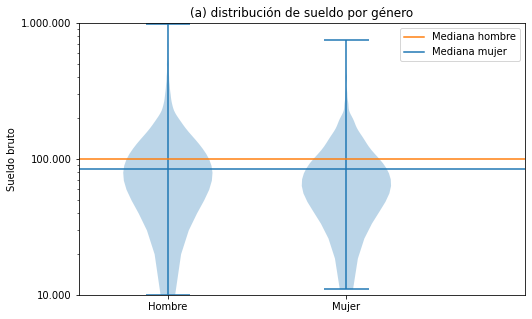

In [9]:
_, ax0 = plt.subplots(1, 1, figsize=(8, 5));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values,
    df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(a) distribución de sueldo por género')
None;

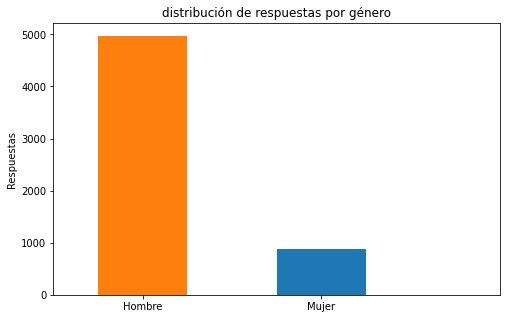

In [10]:
_, ax1 = plt.subplots(1, 1, figsize=(8, 5));
df['Me identifico'].value_counts().sort_values(ascending=False).plot.bar(color=[ch, cm], ax=ax1, rot=0);
ax1.set_xlim(-0.5, 2)
ax1.set_title('distribución de respuestas por género')
ax1.set_ylabel('Respuestas');

In [11]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])

In [12]:
df[df['Me identifico'] == 'Mujer']['region'].value_counts()

AMBA         697
Pampa        153
Cuyo          14
Patagonia      9
NEA            7
NOA            5
Name: region, dtype: int64

In [13]:
regions = ['AMBA', 'Pampa']

<ipython-input-14-0f5ac4369cb4>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10.000', '100.000', '1.000.000'])


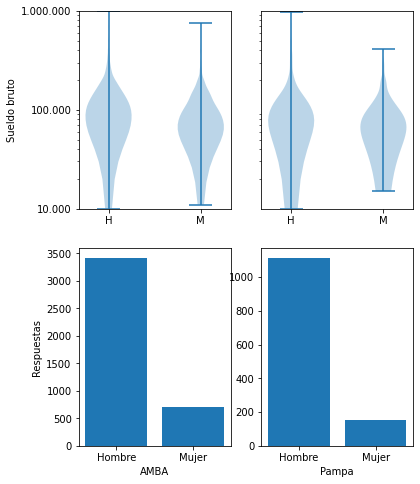

In [14]:
f, axs = plt.subplots(2, len(regions), figsize=(3*len(regions), 8))
for i, region in enumerate(regions):
    ax = plt.subplot(2, len(regions), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['region'] == region)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(regions), i+1+len(regions))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(region)
    s = df[df['region'] == region]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [15]:
degrees = df[df['Me identifico'] == 'Mujer']['Carrera'].value_counts()
degrees = degrees[degrees > 25].keys().to_list()

<ipython-input-16-890b34e4dcfb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10.000', '100.000', '1.000.000'])


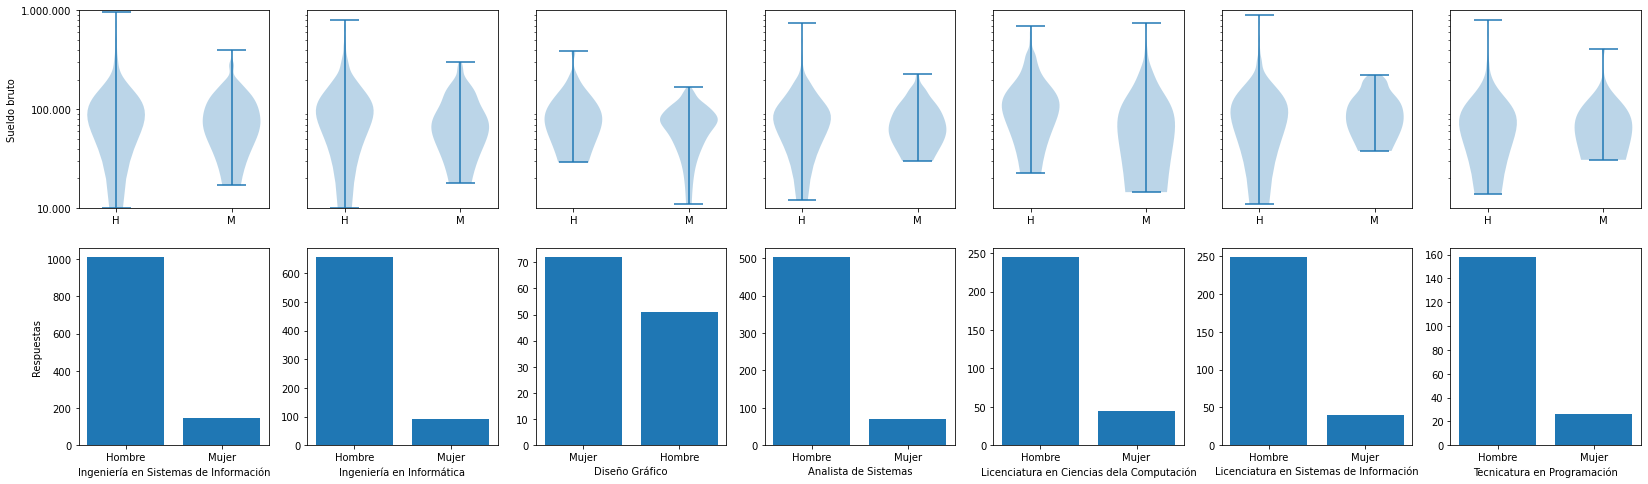

In [16]:
f, axs = plt.subplots(2, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(2, len(degrees), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(degree)
    s = df[df['Carrera'] == degree]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [17]:
df['log2(exp)'] = df['Años de experiencia'].apply(lambda x: math.floor(math.log(x+1, 2)))
df['log2(exp)'].value_counts()

3    1889
2    1568
4    1240
1     819
0     301
5      36
6       1
Name: log2(exp), dtype: int64

In [18]:
exps = sorted(df['log2(exp)'].unique())
exps

[0, 1, 2, 3, 4, 5, 6]

<ipython-input-19-bfaedbaa9a92>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10.000', '100.000', '1.000.000'])


ValueError: zero-size array to reduction operation minimum which has no identity

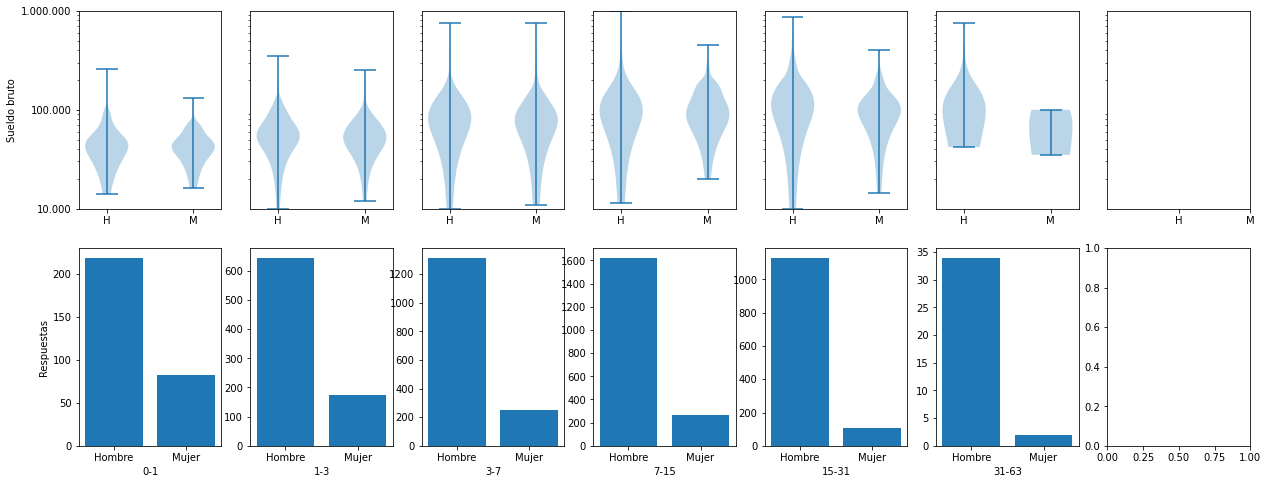

In [19]:
f, axs = plt.subplots(2, len(exps),figsize=(3*len(exps), 8))
for i, exp in enumerate(exps):
    ax = plt.subplot(2, len(exps), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(degrees), i+1+len(degrees))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    s = df[df['log2(exp)'] == exp]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

In [21]:
occupations = df[df['Me identifico'] == 'Mujer']['Trabajo de'].value_counts()
occupations = occupations[occupations > 25].keys().to_list()

<ipython-input-22-ef576bd5c4fa>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10.000', '100.000', '1.000.000'])


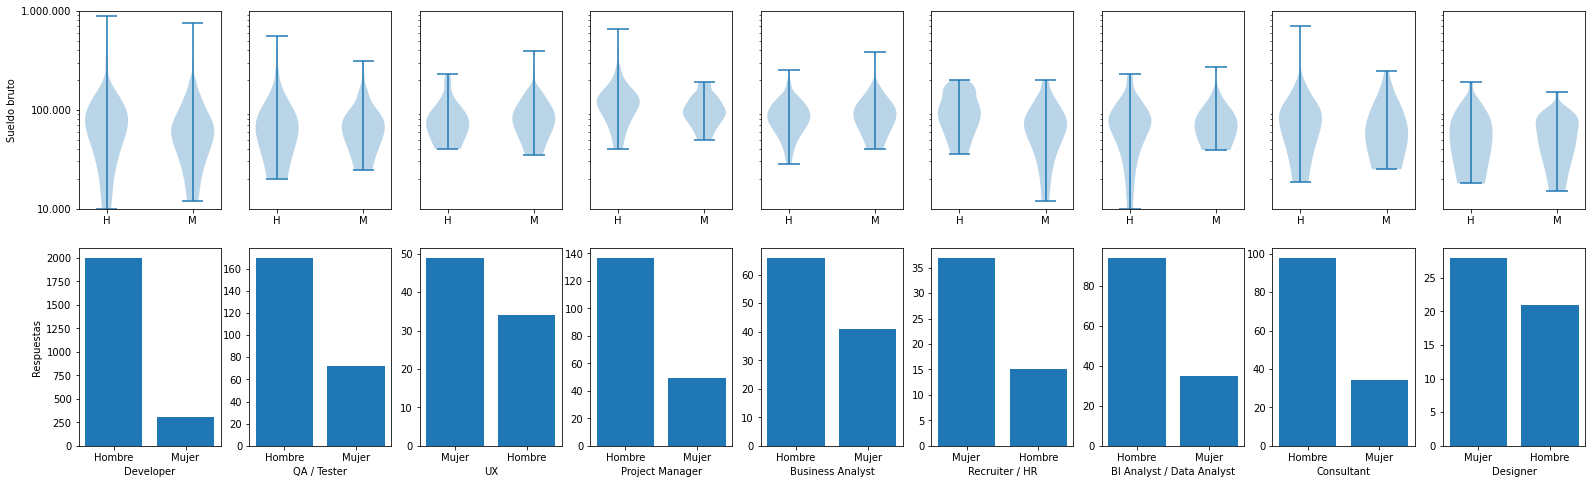

In [22]:
f, axs = plt.subplots(2, len(occupations),figsize=(3*len(occupations), 8))
for i, occupation in enumerate(occupations):
    ax = plt.subplot(2, len(occupations), i+1)
    ax.set_yscale('log')
    ax.set_ylim(10_000, 1_000_000)
    if i == 0:
        ax.set_ylabel('Sueldo bruto')
        ax.set_yticklabels(['10.000', '100.000', '1.000.000'])
        ax.set_yticks([10_000, 100_000, 1_000_000])
    else:
        ax.set_yticks([])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['Salario mensual BRUTO (en tu moneda local)'].values,
    ]);

    ax = plt.subplot(2, len(occupations), i+1+len(occupations))
    if i == 0:
        ax.set_ylabel('Respuestas')
    ax.set_xlabel(occupation)
    s = df[df['Trabajo de'] == occupation]['Me identifico'].value_counts()
    ax.bar(s.keys(), s.values)

## Analizar la brecha de género

El sueldo depende de muchas cosas y es difícil de determinar. Si vemos una disparidad en los sueldos de por ejemplo BI, o de gente con más experiencia, es difícil establecer la causalidad para medirlos. Lo que podemos hacer es usar un modelo que establezca cuánto ganaría cada persona que respondió la encuesta al cambiarle su género, tomando el supuesto de que el modelo puede encontrar estas relaciones entre las distintas características.

In [35]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr(salary)'], axis=1)
df['e_m(salary)'] = df.apply(lambda row: row['e(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr(salary)'], axis=1)
df['e_g_diff(salary)'] = (df['e_h(salary)'] - df['e_m(salary)']) / df['e_h(salary)']

In [38]:
(df['e_h(salary)'].median(), df['e_m(salary)'].median())

(106613.6484375, 99976.6484375)

In [39]:
df[df['Me identifico'] == 'Hombre']['e_h(salary)'].median(),df[df['Me identifico'] == 'Mujer']['e_h(salary)'].median()

(108454.6484375, 98349.25)

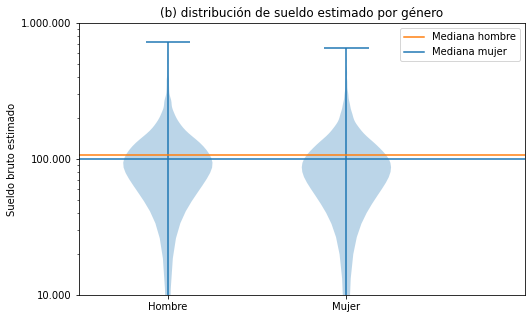

In [40]:
_, (ax0) = plt.subplots(1, 1, figsize=(8, 5));
ax0.axhline(df['e_h(salary)'].median(), c=ch)
ax0.axhline(df['e_m(salary)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto estimado')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df['e_h(salary)'].values,
    df['e_m(salary)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(b) distribución de sueldo estimado por género');

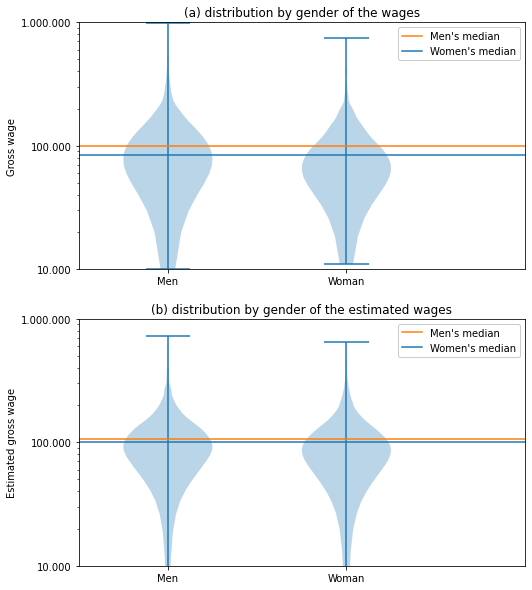

In [41]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 10));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Gross wage')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Men', 'Woman'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].values,
    df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].values,
]);
legend = ax0.legend(["Men's median", "Women's median"])
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax0.set_title('(a) distribution by gender of the wages')
ax0.patch.set_alpha(0.0)

ax1.axhline(df['e_h(salary)'].median(), c=ch)
ax1.axhline(df['e_m(salary)'].median(), c=cm)
ax1.set_ylabel('Estimated gross wage')
ax1.set_yscale('log')
ax1.set_xlim(0.5, 3)
ax1.set_ylim(10_000, 1_000_000)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Men', 'Woman'])
ax1.set_yticks([10_000, 100_000, 1_000_000])
ax1.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax1.violinplot([
    df['e_h(salary)'].values,
    df['e_m(salary)'].values,
]);
legend = ax1.legend(["Men's median", "Women's median"])
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax1.set_title('(b) distribution by gender of the estimated wages');
ax1.patch.set_alpha(0.0);

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.2-9cIj2gCo/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.2-9cIj2gCo/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


''

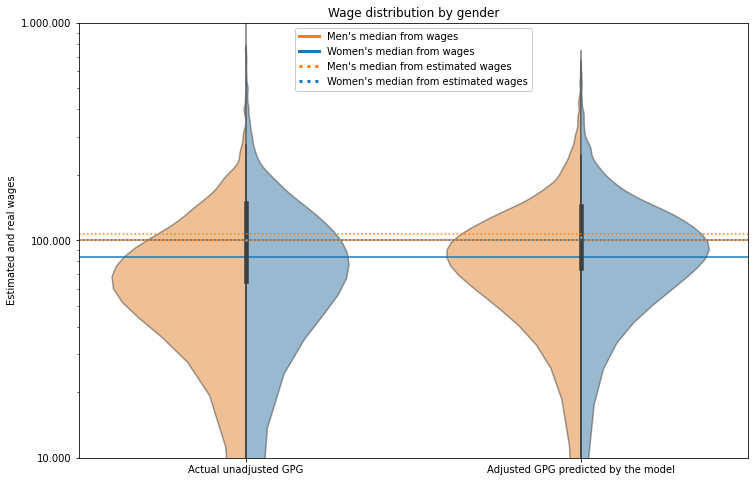

In [42]:
from matplotlib.lines import Line2D
import seaborn as sns

b = df[['Me identifico', 'Salario mensual BRUTO (en tu moneda local)']]
b.loc[:, 'source'] = 'Actual unadjusted GPG'
a = df[['e_h(salary)']].rename(columns={'e_h(salary)': 'Salario mensual BRUTO (en tu moneda local)'})
a['Me identifico'] = 'Hombre'
a['source'] = 'Adjusted GPG predicted by the model'
c = df[['e_m(salary)']].rename(columns={'e_m(salary)': 'Salario mensual BRUTO (en tu moneda local)'})
c['Me identifico'] = 'Mujer'
c['source'] = 'Adjusted GPG predicted by the model'
violindata = pd.concat((b, a, c), axis=0)

_, ax0 = plt.subplots(1, 1, figsize=(12, 8));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'].median(), c=cm)
ax0.set_ylabel('Gross wage')
ax0.set_yscale('log')
#ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Men', 'Woman'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
g = sns.violinplot(
    x='source',
    y='Salario mensual BRUTO (en tu moneda local)',
    hue='Me identifico',
    data=violindata,
    ax=ax0,
    split=True,
    palette=(ch, cm),
);
for violin in g.collections:
    violin.set_alpha(0.5)
g.legend_.remove()
legend = ax0.legend(handles=[
    Line2D([0], [0], color=ch, lw=3, label="Men's median from wages"),
    Line2D([0], [0], color=cm, lw=3, label="Women's median from wages"),
    Line2D([0], [0], color=ch, lw=3, linestyle='dotted', label="Men's median from estimated wages"),
    Line2D([0], [0], color=cm, lw=3, linestyle='dotted', label="Women's median from estimated wages"),
], loc='upper center')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 1, 0.))
ax0.set_title('Wage distribution by gender')
ax0.patch.set_alpha(0.0)

ax0.set_xlabel('')
ax0.set_ylabel('Estimated and real wages')
ax0.axhline(df['e_h(salary)'].median(), c=ch, linestyle='dotted')
ax0.axhline(df['e_m(salary)'].median(), c=cm, linestyle='dotted')
;

In [43]:
df

,Timestamp,Me identifico,Tengo,Estoy trabajando en,Dónde estás trabajando,Bolivia,Chile,Colombia,Cuba,Costa Rica,...,¿Instauraron algún beneficio nuevo?,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?",region,log2(exp),e(gender),e(salary),e_gr(salary),e_h(salary),e_m(salary),e_g_diff(salary)
0,7/6/2020 9:56:02,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,No,NaN,AMBA,2,0.599950,66139.898438,58157.835938,58157.835938,66139.898438,-0.137248
1,7/6/2020 9:57:09,Hombre,29,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,No,NaN,NEA,2,0.053871,153571.593750,150802.187500,153571.593750,150802.187500,0.018033
2,7/6/2020 9:58:09,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,"Clases de gimnasia, Clases de meditación, Clas...",NaN,AMBA,1,0.104578,68283.703125,70811.679688,70811.679688,68283.703125,0.035700
3,7/6/2020 9:59:52,Hombre,39,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,No,NaN,NEA,4,0.004003,89845.179688,91055.960938,89845.179688,91055.960938,-0.013476
4,7/6/2020 10:01:27,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,No,NaN,AMBA,3,0.140764,98173.757812,96453.531250,98173.757812,96453.531250,0.017522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410,8/15/2020 22:04:58,Hombre,37,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,No,NaN,AMBA,3,0.005233,41241.046875,35053.218750,41241.046875,35053.218750,0.150041
6411,8/15/2020 22:48:40,Hombre,38,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,No,NaN,AMBA,3,0.003425,110829.218750,105590.328125,110829.218750,105590.328125,0.047270
6412,8/15/2020 23:54:10,Hombre,24,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,"Compra de accesorios (escritorio, monitor, tec...",Mercado Libre,AMBA,1,0.523234,52830.929688,44463.433594,52830.929688,44463.433594,0.158383
6413,8/16/2020 0:45:57,Hombre,28,Argentina,La Pampa,NaN,NaN,NaN,NaN,NaN,...,No,Solo Nubity,Pampa,2,0.021176,90480.546875,86919.203125,90480.546875,86919.203125,0.039360


In [44]:
df['e_g_diff(salary)'].mean()

0.0691820874118595

El modelo aprendiendo de los datos de la encuesta de sueldos concluyó que en promedio le tiene que pagar un 6.92% más a los hombres que a las mujeres, siendo el resto de las respuestas iguales.

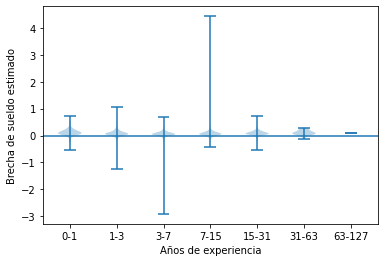

In [45]:
f, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xlabel('Años de experiencia')
ax.set_xticks([e+1 for e in exps])
ax.set_xticklabels([f'{2**exp-1}-{2**(1+exp)-1}' for exp in exps])
ax.axhline()
ax.violinplot([
    df[df['log2(exp)'] == exp]['e_g_diff(salary)'].values
    for exp in exps
]);

El modelo parece haber aprendido que mientras mayor es la experiencia de la persona, mayor debe ser la diferencia entre hombres y mujeres. Esto puede deberse a que los datos muestren un [techo de cristal](https://es.wikipedia.org/wiki/Techo_de_cristal).

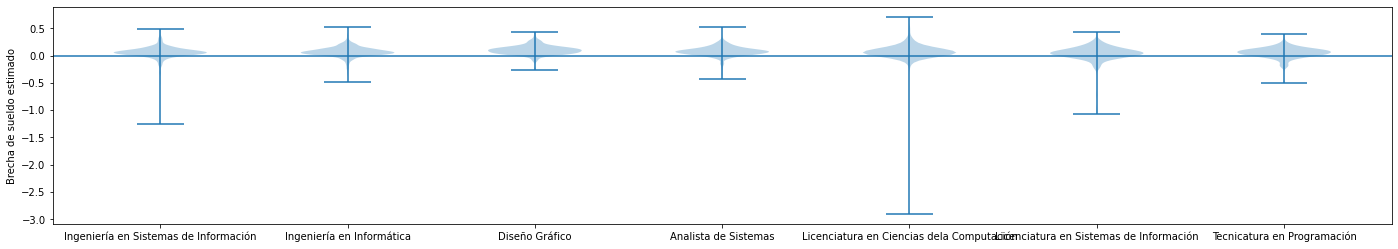

In [46]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(degrees)])
ax.set_xticklabels(degrees)
ax.axhline()
ax.violinplot([
    df[df['Carrera'] == degree]['e_g_diff(salary)'].values
    for degree in degrees
]);

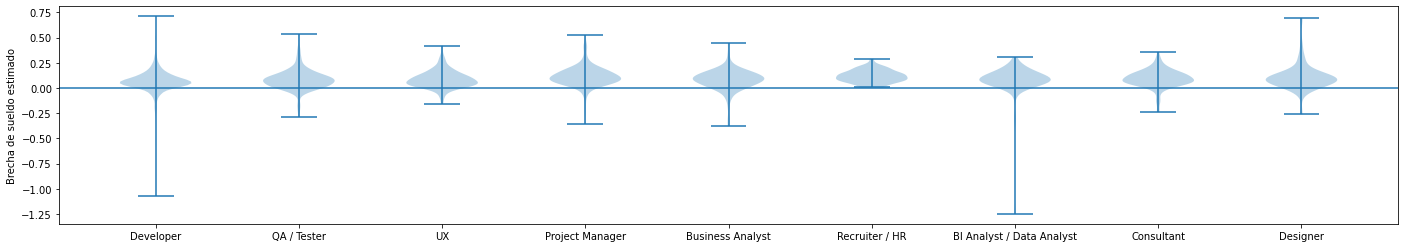

In [47]:
f, axs = plt.subplots(1, 1, figsize=(24, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xticks([e+1 for e, _ in enumerate(occupations)])
ax.set_xticklabels(occupations)
ax.axhline()
ax.violinplot([
    df[df['Trabajo de'] == occupation]['e_g_diff(salary)'].values
    for occupation in occupations
]);

## Modelo "gender-blind"

Creemos ahora un modelo que no considere explicitamente el género y veamos qué pasa con las estimaciones de sueldo de los hombres y de las mujeres comparadas con las estimaciones que lo toman en cuenta (del modelo "gender-aware").

In [48]:
df['Me identifico_copy'] = df['Me identifico']
df['Me identifico'] = ''
df['Orientación sexual_copy'] = df['Orientación sexual']
df['Orientación sexual'] = ''
df['Tengo_copy'] = df['Tengo']
df['Tengo'] = 0
kf = KFold(n_splits=5, shuffle=True, random_state=99)
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'])
    df.loc[df.index[test_index], 'e_gb(salary)'] = model.predict(df.iloc[test_index])
df['Me identifico'] = df['Me identifico_copy']
df['Orientación sexual'] = df['Orientación sexual_copy']
df['Tengo'] = df['Tengo_copy']
df['e_gb_diff(salary)'] = (df['e(salary)'] - df['e_gb(salary)']) / df['e(salary)']

In [49]:
(
df['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_gb_diff(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_gb_diff(salary)'].mean(),
)

(-0.011596398835182783, 0.002899056887666402, -0.09298387848132697)

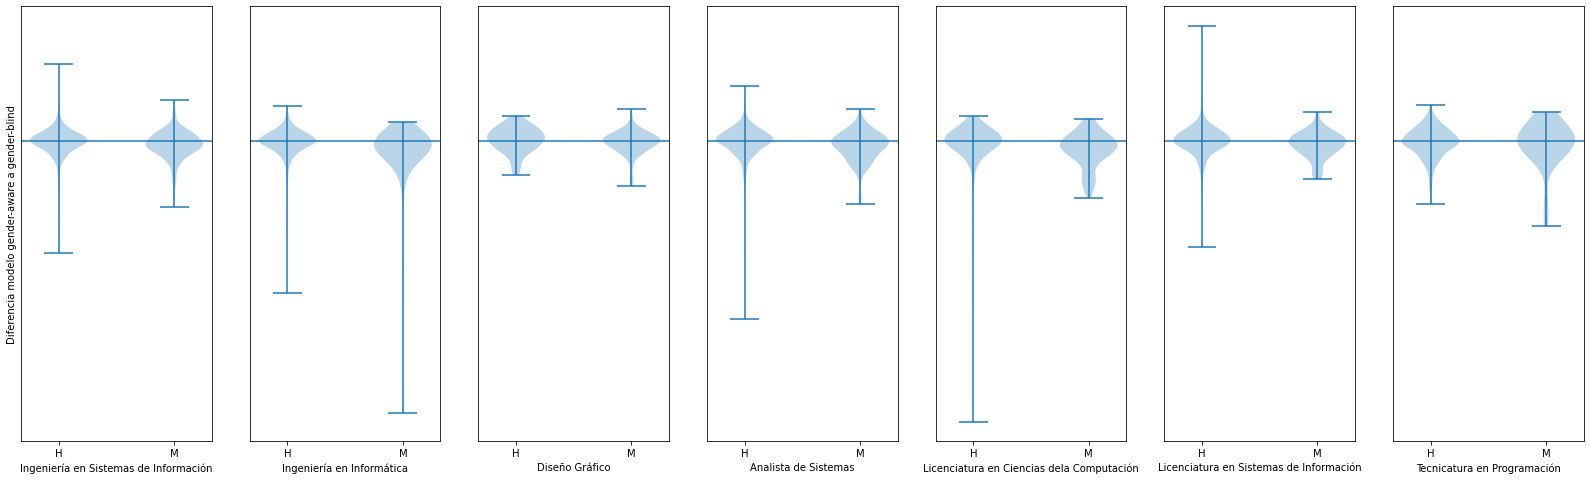

In [50]:
ax = None
f, axs = plt.subplots(1, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['e_gb_diff(salary)'].values,
    ]);

ValueError: zero-size array to reduction operation minimum which has no identity

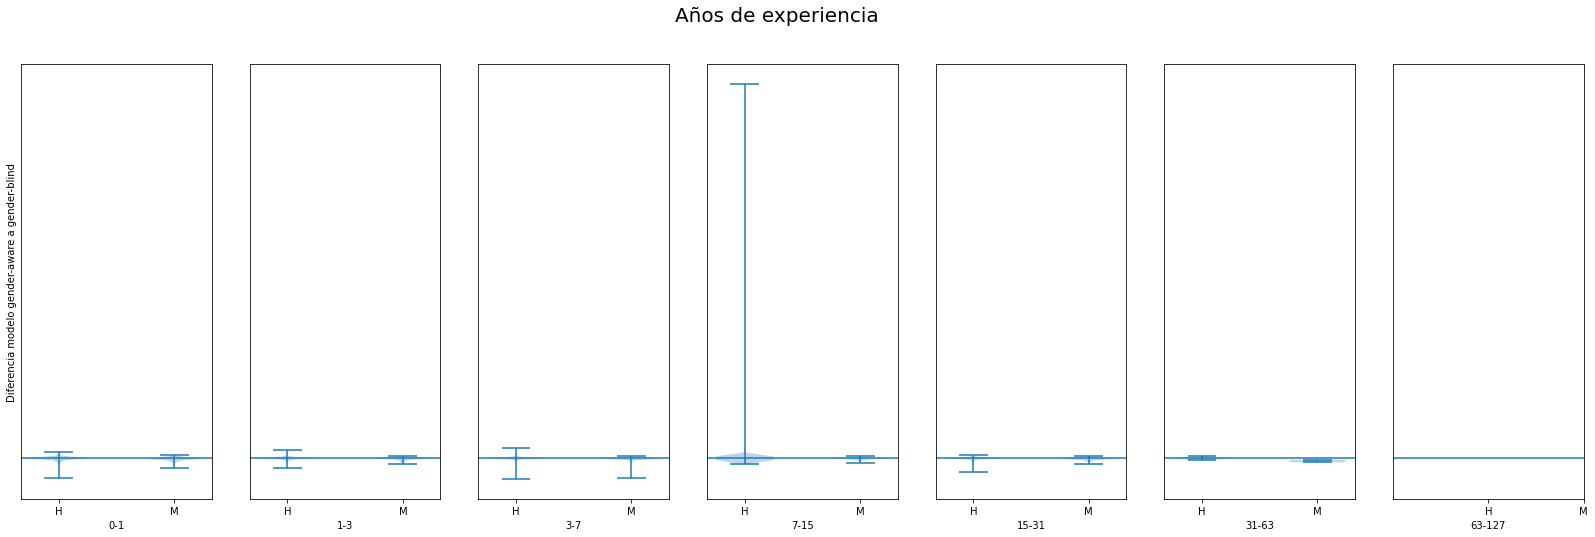

In [51]:
ax = None
f, axs = plt.subplots(2, len(exps),figsize=(4*len(exps), 8))
f.suptitle('Años de experiencia', fontsize=20)
for i, exp in enumerate(exps):
    ax = plt.subplot(1, len(exps), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(exp)
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['e_gb_diff(salary)'].values,
    ]);

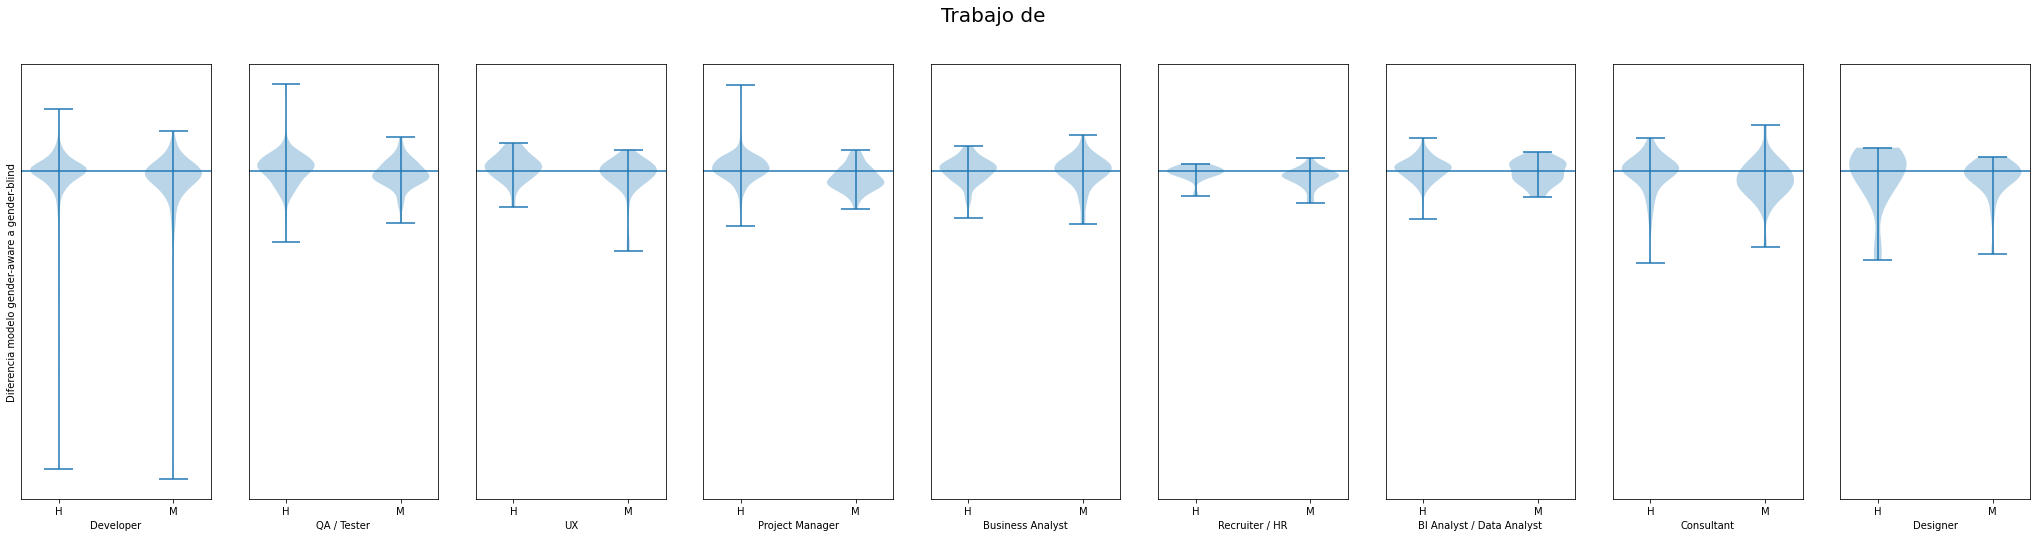

In [53]:
ax = None
f, axs = plt.subplots(1, len(occupations),figsize=(4*len(occupations), 8))
f.suptitle('Trabajo de', fontsize=20)
for i, occupation in enumerate(occupations):
    ax = plt.subplot(1, len(occupations), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo gender-aware a gender-blind')
    else:
        ax.set_yticks([])
    ax.set_xlabel(occupation)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['e_gb_diff(salary)'].values,
    ]);

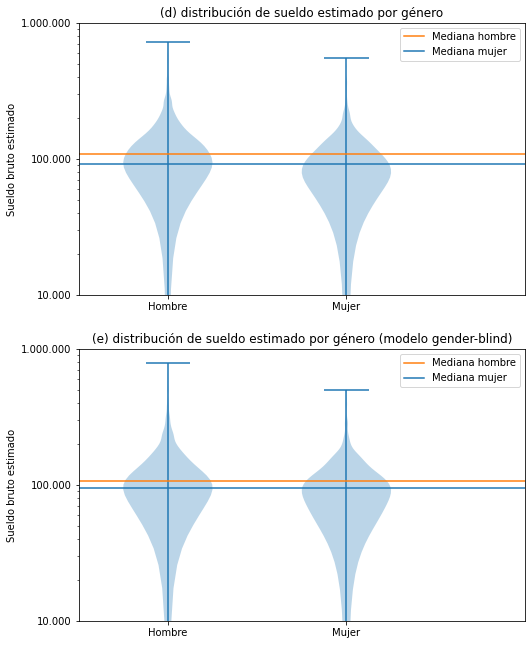

In [54]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 11));
ax0.axhline(df[df['Me identifico'] == 'Hombre']['e(salary)'].median(), c=ch)
ax0.axhline(df[df['Me identifico'] == 'Mujer']['e(salary)'].median(), c=cm)
ax0.set_ylabel('Sueldo bruto estimado')
ax0.set_yscale('log')
ax0.set_xlim(0.5, 3)
ax0.set_ylim(10_000, 1_000_000)
ax0.set_xticks([1, 2])
ax0.set_xticklabels(['Hombre', 'Mujer'])
ax0.set_yticks([10_000, 100_000, 1_000_000])
ax0.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax0.violinplot([
    df[df['Me identifico'] == 'Hombre']['e(salary)'].values,
    df[df['Me identifico'] == 'Mujer']['e(salary)'].values,
]);
ax0.legend(['Mediana hombre', 'Mediana mujer'])
ax0.set_title('(d) distribución de sueldo estimado por género');

ax1.axhline(df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].median(), c=ch)
ax1.axhline(df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].median(), c=cm)
ax1.set_ylabel('Sueldo bruto estimado')
ax1.set_yscale('log')
ax1.set_xlim(0.5, 3)
ax1.set_ylim(10_000, 1_000_000)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Hombre', 'Mujer'])
ax1.set_yticks([10_000, 100_000, 1_000_000])
ax1.set_yticklabels(['10.000', '100.000', '1.000.000'])
ax1.violinplot([
    df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].values,
    df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].values,
]);
ax1.legend(['Mediana hombre', 'Mediana mujer'])
ax1.set_title('(e) distribución de sueldo estimado por género (modelo gender-blind)');

In [55]:
(
df[df['Me identifico'] == 'Hombre']['e(salary)'].median(),
df[df['Me identifico'] == 'Mujer']['e(salary)'].median(),
df[df['Me identifico'] == 'Hombre']['e_gb(salary)'].median(),
df[df['Me identifico'] == 'Mujer']['e_gb(salary)'].median()
)

(108454.6484375, 91111.0703125, 107615.9296875, 95547.9609375)

Al excluir el género en el modelo el sueldo estimado de los mujeres se aumenta más que el de los hombres, pero la brecha persiste.

### Explicar la diferencia

Vemos que el modelo aprendió que las mujeres por el mismo trabajo tienen que ganar menos, y no sólo eso, cuando le escondemos el género la diferencia se incrementa. Vamos a tratar de ver qué están viendo los modelos para ver qué características cobran más importancia al ser gender-blind. También podemos intentar comparar una versión de modelo sólo para hombres con una sólo de mujeres y ver en qué se fijan en cada caso.

In [56]:
models = {}
df['Me identifico_copy'] = df['Me identifico']
df['Orientación sexual_copy'] = df['Orientación sexual']
df['Tengo_copy'] = df['Tengo']

models['gender-aware'] = Model().fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = ''
df['Orientación sexual'] = ''
df['Tengo'] = 0
models['gender-unaware'] = Model().fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
df['Me identifico'] = df['Me identifico_copy']
df['Orientación sexual'] = df['Orientación sexual_copy']
df['Tengo'] = df['Tengo_copy']

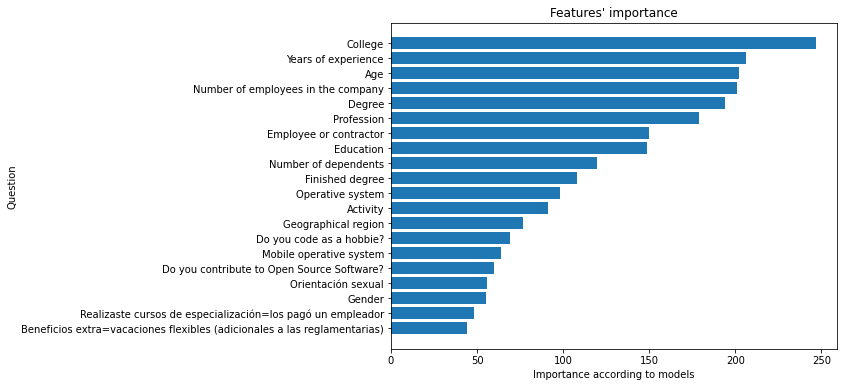

In [57]:
features = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data = data.reset_index()
data['question'] = data['index'].apply(lambda x: x if (
    '=' not in x or
    x.startswith('Bases de datos') or
    x.startswith('Beneficios extra') or
    x.startswith('Frameworks, herramientas y librerías') or
    x.startswith('IDEs') or
    x.startswith('Lenguajes de programación') or
    x.startswith('Plataformas') or
    x.startswith('QA / Testing') or
    x.startswith('Realizaste cursos de especialización')
) else x.split('=')[0])
data = data.drop('index', axis=1).groupby('question').sum()
data = data.sort_values(by = "score", ascending=True).tail(20)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.barh([{
    'Años de experiencia': 'Years of experience',
    'Carrera': 'Degree',
    'Cantidad de empleados': 'Number of employees in the company',
    'Trabajo de': 'Profession',
    'Tengo': 'Age',
    'Nivel de estudios alcanzado': 'Education',
    'Universidad': 'College',
    'Estado': 'Finished degree',
    '¿Gente a cargo?': 'Number of dependents',
    'Actividad principal': 'Activity',
    'Tipo de contrato': 'Employee or contractor',
    '¿Qué SO usás en tu laptop/PC para trabajar?': 'Operative system',
    'Me identifico': 'Gender',
    '¿Contribuís a proyectos open source?': 'Do you contribute to Open Source Software?',
    '¿Y en tu celular?': 'Mobile operative system',
    '¿Programás como hobbie?': 'Do you code as a hobbie?',
    'region': 'Geographical region',
    'Beneficios extra=sueldo dolarizado': 'Salary in dollars',
    'Realizaste cursos de especialización=de forma particular': 'Did you do a specialization course?',
    'Plataformas=windows server': 'Do you use Windows Server?',
}.get(x, x) for x in data.index], data['score'])
ax.set_title("Features' importance")
ax.set_ylabel('Question')
ax.set_xlabel('Importance according to models')
ax.patch.set_alpha(0.0)
None;

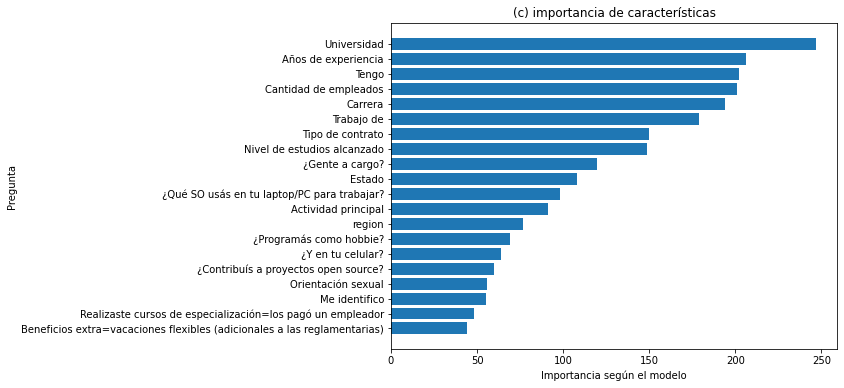

In [58]:
features = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data = data.reset_index()
data['question'] = data['index'].apply(lambda x: x if (
    '=' not in x or
    x.startswith('Bases de datos') or
    x.startswith('Beneficios extra') or
    x.startswith('Frameworks, herramientas y librerías') or
    x.startswith('IDEs') or
    x.startswith('Lenguajes de programación') or
    x.startswith('Plataformas') or
    x.startswith('QA / Testing') or
    x.startswith('Realizaste cursos de especialización')
) else x.split('=')[0])
data = data.drop('index', axis=1).groupby('question').sum()
data = data.sort_values(by = "score", ascending=True).tail(20)
plt.figure(figsize=(8, 6))
plt.barh(data.index, data['score'])
plt.title('(c) importancia de características')
plt.ylabel('Pregunta')
plt.xlabel('Importancia según el modelo')
None;

In [59]:
data.sort_values('score', ascending=False)

,score
question,
Universidad,247
Años de experiencia,206
Tengo,202
Cantidad de empleados,201
Carrera,194
Trabajo de,179
Tipo de contrato,150
Nivel de estudios alcanzado,149
¿Gente a cargo?,120


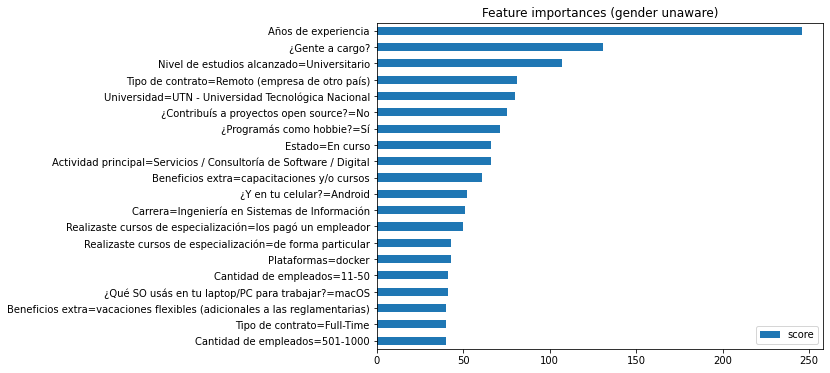

In [60]:
features = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
keys = [features[int(i)] for i in list(feature_important.keys())]
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True).tail(20)
data.plot(kind='barh', figsize=(8, 6), title='Feature importances (gender unaware)');

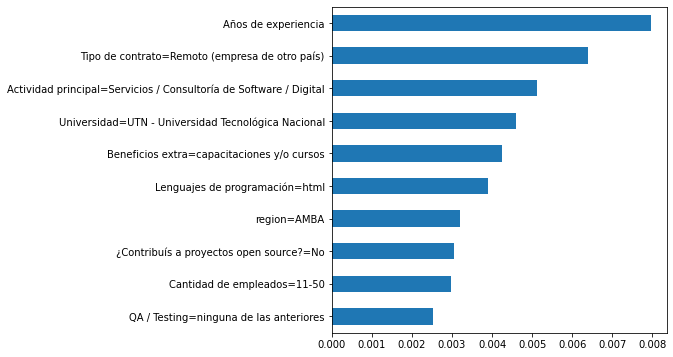

In [61]:
scores = models['gender-aware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-aware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_aw = {f[int(k)]: v / sum_scores for k, v in scores.items()}

scores = models['gender-unaware'].regressor_.get_booster().get_score(importance_type='weight')
sum_scores = sum(scores.values())
f = models['gender-unaware'].valid_words_ + [ '¿Gente a cargo?', 'Años de experiencia', 'Tengo']
feature_important_unaw = {f[int(k)]: v / sum_scores for k, v in scores.items()}

diff = pd.Series({k: np.abs(v - feature_important_aw.get(k, 0)) for k, v in feature_important_unaw.items()}).sort_values()
plt.subplots(1, 1, figsize=(6, 6))
diff.tail(10).plot.barh(ax=plt.subplot(1,1,1));

Cuando le sacamos género al modelo (unaware) la importancia se diluye en el resto de las características sin que ninguna prevalezca. No existe una característica que funcione como [proxy](https://en.wikipedia.org/wiki/Proxy_(statistics)) claro.

## Cuán injustamente malo es el modelo

El modelo es el mejor modelo que pudimos lograr. Tiene un r2 de 0.6244, lo que quiere decir que no puede explicar un 38%. Todavía más podemos ver cómo si el error que comete es igual para hombres que para mujeres, y no sólo eso sino que ya vimos que las estimaciones para mujeres son un 7% inferiores que la de los hombres. Como en la muestra que tenemos hay menos mujeres que hombres (menos de un 15% del total) sabemos que el modelo priorizó la precisión de los hombres, por priorizar la precisión total.

In [62]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e(salary)']))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df['e(salary)']))

r2 hombre 0.5247233205421085
r2 mujer 0.35652156583611927
r2 total 0.520699656947861


El error de predicción debería ser normal si el modelo no está sesgado. Veamos qué pasa por género.

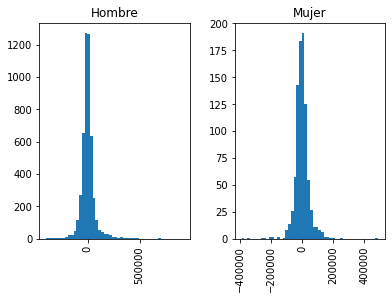

In [63]:
df['e(salary)_err'] = (df['Salario mensual BRUTO (en tu moneda local)'] - df['e(salary)'])
df.hist(column='e(salary)_err', bins=50, by=df['Me identifico']);

In [64]:
(
scipy.stats.normaltest(df['e(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Hombre']['e(salary)_err']),
scipy.stats.normaltest(df[df['Me identifico'] == 'Mujer']['e(salary)_err']),
)

(NormaltestResult(statistic=3584.186082835181, pvalue=0.0),
 NormaltestResult(statistic=3077.2307548777094, pvalue=0.0),
 NormaltestResult(statistic=235.51072994493208, pvalue=7.235937015896296e-52))

In [65]:
print(f"total mean={np.mean(df['e(salary)_err'])}, var={np.var(df['e(salary)_err'])}")
print(f"hombres mean={np.mean(df[df['Me identifico'] == 'Hombre']['e(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Hombre']['e(salary)_err'])}")
print(f"mujeres mean={np.mean(df[df['Me identifico'] == 'Mujer']['e(salary)_err'])}, var={np.var(df[df['Me identifico'] == 'Mujer']['e(salary)_err'])}")

total mean=-12.809192573278919, var=4977049582.030627
hombres mean=484.5218398162846, var=5414484514.157487
mujeres mean=-2805.1684015492588, var=2511802367.407006


El error en ambos grupos es normal con media cero, pero para las mujeres presenta es un poco menos normal y tiene más varianza.

Probemos aumentarle un 7% el sueldo a todas las mujeres y ver su efecto en la calidad de los resultados.

In [66]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e(salary)'] * 1.07))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df.apply(lambda row: row['e(salary)'] * (1.0 if row['Me identifico'] == 'Hombre' else 1.07), axis=1)))

r2 hombre 0.5247233205421085
r2 mujer 0.2973145119192657
r2 total 0.517324378069449


El r2 baja, como era esperable, pero bastante poco. El r2 de mujeres también baja, más, y esto se explica porque le estamos agregando un error sistemático, haciendo [discriminación positiva](https://es.wikipedia.org/wiki/Discriminaci%C3%B3n_positiva).

## Hacia un modelo más justo

Que el error sea mayor con las mujeres puede deberse a que sean menos, y por lo tanto su peso en la evaluación de la inferencia es menor. Podemos compensar esta asimetría considerando a cada mujer como si apareciese seis veces.

In [67]:
men_per_woman = df['Me identifico'].value_counts()['Hombre'] / df['Me identifico'].value_counts()['Mujer']

In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_models = []
for train_index, test_index in kf.split(df):
    model = Model().fit(df.iloc[train_index], df.iloc[train_index]['Salario mensual BRUTO (en tu moneda local)'],
                       sample_weight=df.iloc[train_index]['Me identifico'].apply(lambda g: 1.0 if g == 'Hombre' else men_per_woman))
    df.loc[df.index[test_index], 'e_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    df.loc[df.index[test_index], 'e_gr_weighted(salary)'] = model.predict(df.iloc[test_index])
    df['Me identifico'] = df['Me identifico'].apply(lambda g: {'Hombre': 'Mujer', 'Mujer': 'Hombre'}[g])
    kf_models.append(model)
df['e_h_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Hombre' else row['e_gr_weighted(salary)'], axis=1)
df['e_m_weighted(salary)'] = df.apply(lambda row: row['e_weighted(salary)'] if row['Me identifico'] == 'Mujer' else row['e_gr_weighted(salary)'], axis=1)
df['e_g_diff_weighted(salary)'] = (df['e_h_weighted(salary)'] - df['e_m_weighted(salary)']) / df['e_h_weighted(salary)']

In [69]:
(
df['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Hombre')]['e_g_diff_weighted(salary)'].mean(),
df[(df['Me identifico'] == 'Mujer')]['e_g_diff_weighted(salary)'].mean(),
)

(0.07675219293401064, 0.07397014548565135, 0.09237252487852739)

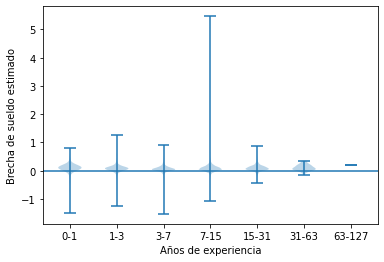

In [70]:
f, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('Brecha de sueldo estimado')
ax.set_xlabel('Años de experiencia')
ax.set_xticks([e+1 for e in exps])
ax.set_xticklabels([f'{2**exp-1}-{2**(1+exp)-1}' for exp in exps])
ax.axhline()
ax.violinplot([
    df[df['log2(exp)'] == exp]['e_g_diff_weighted(salary)'].values
    for exp in exps
]);

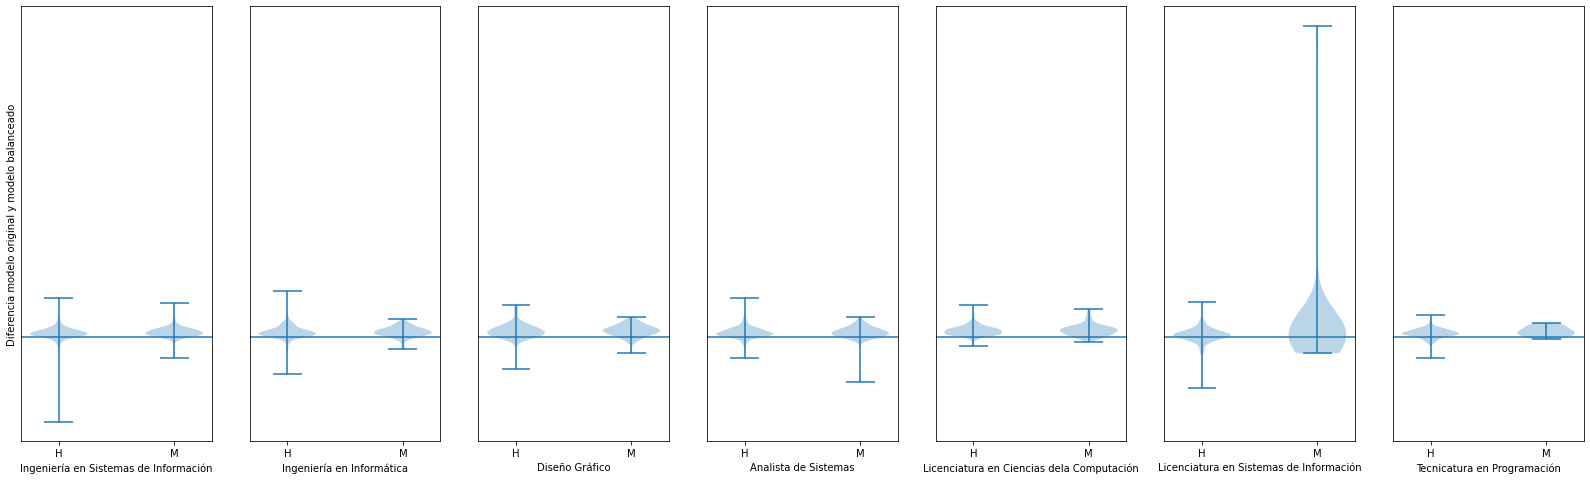

In [71]:
ax = None
f, axs = plt.subplots(1, len(degrees),figsize=(4*len(degrees), 8))
for i, degree in enumerate(degrees):
    ax = plt.subplot(1, len(degrees), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(degree)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Carrera'] == degree)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Carrera'] == degree)]['e_g_diff_weighted(salary)'].values,
    ]);

ValueError: zero-size array to reduction operation minimum which has no identity

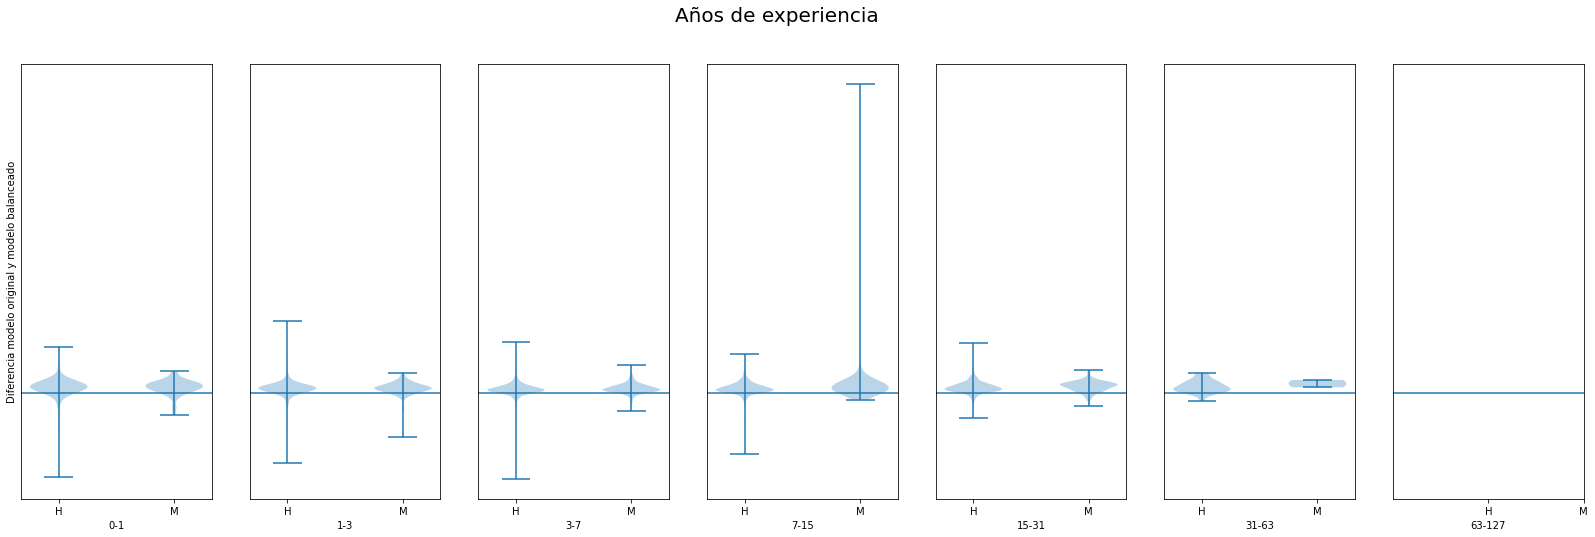

In [72]:
ax = None
f, axs = plt.subplots(2, len(exps),figsize=(4*len(exps), 8))
f.suptitle('Años de experiencia', fontsize=20)
for i, exp in enumerate(exps):
    ax = plt.subplot(1, len(exps), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(exp)
    ax.set_xlabel(f'{2**exp-1}-{2**(1+exp)-1}')
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['log2(exp)'] == exp)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['log2(exp)'] == exp)]['e_g_diff_weighted(salary)'].values,
    ]);

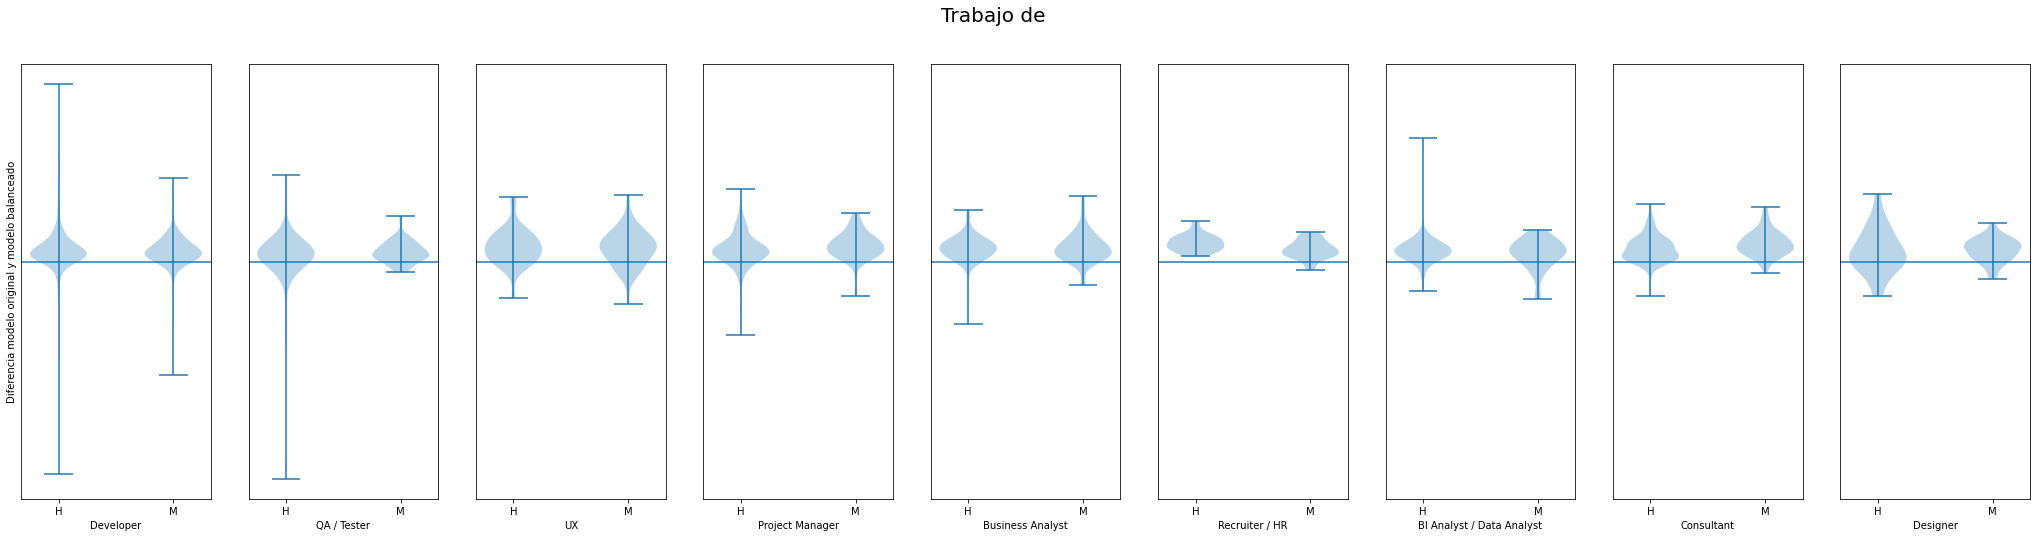

In [74]:
ax = None
f, axs = plt.subplots(1, len(occupations),figsize=(4*len(occupations), 8))
f.suptitle('Trabajo de', fontsize=20)
for i, occupation in enumerate(occupations):
    ax = plt.subplot(1, len(occupations), i+1, sharey=ax)
    if i == 0:
        ax.set_ylabel('Diferencia modelo original y modelo balanceado')
    else:
        ax.set_yticks([])
    ax.set_xlabel(occupation)
    ax.axhline()
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['H', 'M'])
    ax.violinplot([
        df[(df['Me identifico'] == 'Hombre') & (df['Trabajo de'] == occupation)]['e_g_diff_weighted(salary)'].values,
        df[(df['Me identifico'] == 'Mujer') & (df['Trabajo de'] == occupation)]['e_g_diff_weighted(salary)'].values,
    ]);

In [75]:
print('r2 hombre', r2_score(df[df['Me identifico'] == 'Hombre']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Hombre']['e_weighted(salary)']))
print('r2 mujer', r2_score(df[df['Me identifico'] == 'Mujer']['Salario mensual BRUTO (en tu moneda local)'], df[df['Me identifico'] == 'Mujer']['e_weighted(salary)']))
print('r2 total', r2_score(df['Salario mensual BRUTO (en tu moneda local)'], df['e_weighted(salary)']))

r2 hombre 0.5228136917189861
r2 mujer 0.4671778377631831
r2 total 0.5252295515335549


Parece sorprendente que el r2 de las mujeres baje siendo que les estamos dando más peso. Sin embargo tienen más peso en el entrenamiento pero el calculo de r2 no cambia. Esto quiere decir que al darle menos peso a los hombres (el peso es ganancia cero) estamos perdiendo información que era útil para explicar las variaciones salariales. Sin embargo vemos que el promedio de sueldo de las mujeres mejora alrededor de 2% por encima del de los hombres, lo que quiere decir que por esta penalidad en que incurrimos, la brecha se achica.

## Clasificador

Me intriga pensar cuán posible es determinar el género de una persona dadas sus otras respuestas. Antes vimos que sacar género no generaba un proxy claro, pero si con una combinación de características se puede determinar el género de alguien, el modelo puede identificarlo implícitamente.

El modelo va a tener la misma entrada que el anterior, excepto género, y la salida va a ser 1 para Mujer y 0 para Hombre. Para evaluarlo tenemos que ver cómo establecer el corte. El modelo va a dar un número entre 0 y 1, mientras más cercano a 1 más parecerá que es un mujer, pero de alguna forma hay que agarrar este número y transformarlo en binario. Hay que considerar que al evaluar tenemos un desbalanceo de los datos, alrededor de 6 hombres por mujer, así que un modelo que diga siempre hombre tiene un 85% de _accuracy_. Vamos a balancear esto diciendo que el corte debería generar la misma proporción de errores de cada tipo, es decir, de hombre que predice como mujer y de mujeres que predice como hombres.

Técnicamente estamos hablado de la accuracy _balanceada_. Un modelo aleatorio tendría un 50% en esta métricas.

In [76]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
class GModel:
    def __init__(self, **params):
        self.classifier_ = xgb.XGBClassifier(**params)

    def get_params(self, deep=True):
        return self.classifier_.get_params(deep=deep)

    def set_params(self, **params):
        return self.classifier_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.classifier_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.classifier_.predict(X.apply(self.encode_row, axis=1).astype(float))
   
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return self.classifier_.score(X.apply(self.encode_row, axis=1).astype(float), y)

In [77]:
from sklearn.metrics import recall_score, precision_score

kf = KFold(n_splits=5, shuffle=True, random_state=99)
kf_gmodels = []
for train_index, test_index in kf.split(df):
    men_per_woman = (df.iloc[train_index]['Me identifico'] == 'Hombre').sum() / (df.iloc[train_index]['Me identifico'] == 'Mujer').sum()
    model = GModel().fit(
        df.iloc[train_index],
        (df.iloc[train_index]['Me identifico'] == 'Mujer').astype(float),
       sample_weight=df.iloc[train_index]['Me identifico'].apply(lambda g: 1.0 if g == 'Hombre' else men_per_woman)
    )
    df.loc[df.index[test_index], 'e(gender)'] = model.predict_proba(df.iloc[test_index])[:, 1]
    kf_gmodels.append(model)

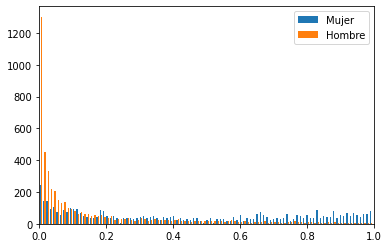

In [78]:
plt.xlim(0, 1)
plt.hist([
    df[df['Me identifico'] == 'Mujer']['e(gender)'].values,
    df[df['Me identifico'] == 'Hombre']['e(gender)'].values,
], weights=[
    np.ones((df['Me identifico'] == 'Mujer').sum()) * (df['Me identifico'] == 'Hombre').sum()/(df['Me identifico'] == 'Mujer').sum(),
    np.ones((df['Me identifico'] == 'Hombre').sum()),
], bins=100, label=['Mujer', 'Hombre']);
plt.legend(loc='upper right');

''

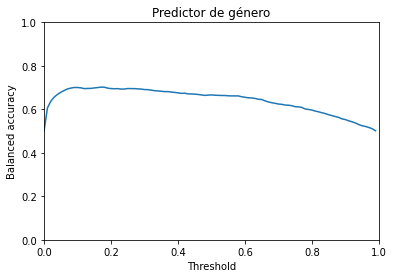

In [79]:
values = {}
for i in range(0, 100):
    values[i/100] = balanced_accuracy_score(df['Me identifico'] == 'Mujer', df['e(gender)'] > i / 100)
ax = pd.Series(values).plot()
ax.set_xlabel('Threshold')
ax.set_xlim(0, 1)
ax.set_ylabel('Balanced accuracy')
ax.set_ylim(0, 1.0)
ax.set_title('Predictor de género')
;

El modelo predictor de género acierta, como máximo, un 70% de las veces, un poco mejor que el 50% de base. No parece ser fácil establecer el género de una persona sólo con sus respuestas.

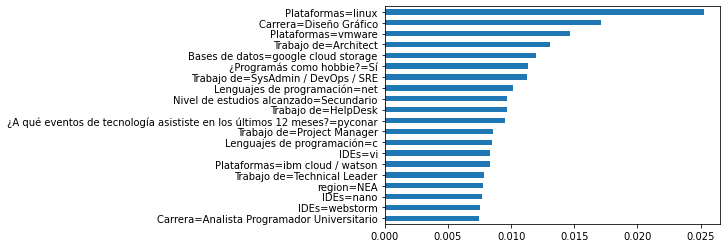

In [80]:
pd.Series(dict(zip(kf_gmodels[0].valid_words_ + [
'¿Gente a cargo?',
'Años de experiencia',
'Tengo',
],
kf_gmodels[0].classifier_.feature_importances_))).sort_values().tail(20).plot.barh();

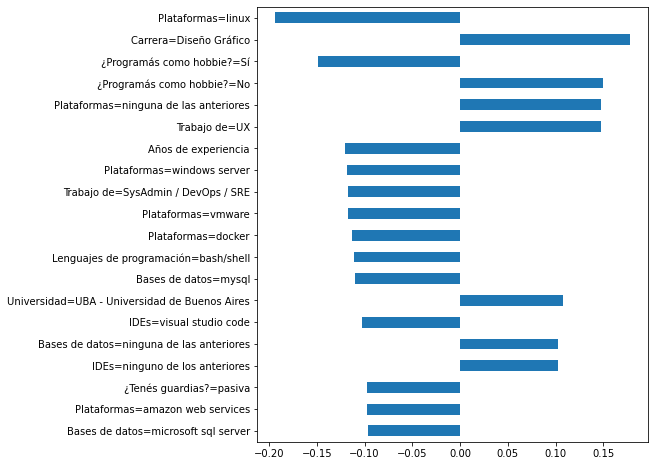

In [81]:
col_to_name = dict(zip(range(len(kf_gmodels[0].valid_words_)+3), kf_gmodels[0].valid_words_ + ['¿Gente a cargo?','Años de experiencia','Tengo',]))

df_encoded = df.apply(kf_gmodels[0].encode_row, axis=1)
df_corr = pd.concat((df_encoded, pd.DataFrame((df['Me identifico'] == 'Mujer').rename('Mujer'))), axis=1).corr()
df_corr['sort'] = np.abs(df_corr['Mujer'])
df_corr = df_corr.sort_values('sort')['Mujer'].drop('Mujer').tail(20).rename(lambda col: col_to_name[col], axis=1).plot.barh(figsize=(7, 8));

## Características que más afectan el sueldo

Veamos cómo las principales características del modelo de predicción afecta el sueldo de distinta manera a hombres y mujeres.

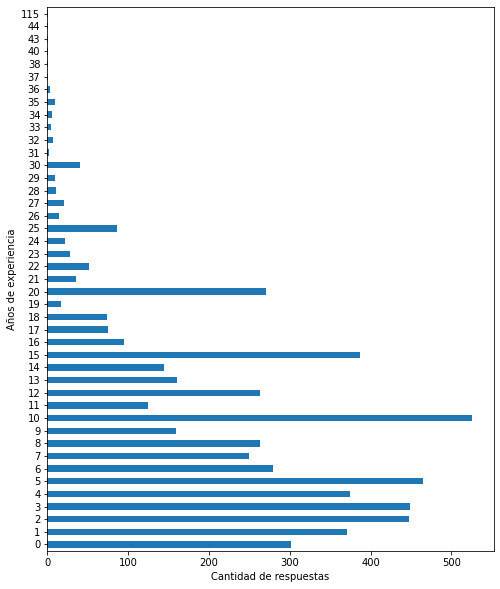

In [82]:
ax = df['Años de experiencia'].apply(math.floor).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Años de experiencia');

Hay picos en 10, 15, 20, 25 y 30. Parece que muchas personas redondearon a un múltiplo de 5 después de los primeros 7 años.

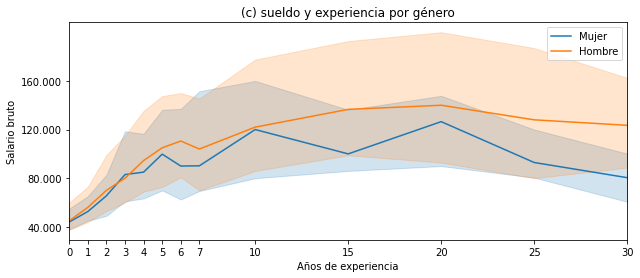

In [83]:
df['exp_round'] = df['Años de experiencia'].apply(lambda x: math.floor(x if x <= 7 else (5 * (x // 5))))
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_xlim(0, 30)
rang = [0, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30]
ax.set_xticks(rang)
w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
ax.plot(w.median())
ax.plot(m.median())
ax.legend(['Mujer', 'Hombre', ])
ax.set_title('(c) sueldo y experiencia por género')
ax.set_yticks([160000, 120000, 80000, 40000])
ax.set_yticklabels(['160.000', '120.000', '80.000', '40.000'])
ax.fill_between(rang, w.quantile(0.25), w.quantile(0.75), color=cm + '33')
ax.fill_between(rang, m.quantile(0.25), m.quantile(0.75), color=ch + '33')
ax.set_ylabel('Salario bruto')
ax.set_xlabel('Años de experiencia')
None;

In [84]:
pd.concat((
    m.quantile(0.25).rename('Q1 Hombre'),
    m.quantile(0.5).rename('Q2 Hombre'),
    m.quantile(0.75).rename('Q3 Hombre'),
    w.quantile(0.25).rename('Q1 Mujer'),
    w.quantile(0.5).rename('Q2 Mujer'),
    w.quantile(0.75).rename('Q3 Mujer'),
), axis=1).astype(int)

,Q1 Hombre,Q2 Hombre,Q3 Hombre,Q1 Mujer,Q2 Mujer,Q3 Mujer
exp_round,,,,,,
0,37500,45000,60000,38000,44000,55000
1,44000,56000,73000,45000,52600,65250
2,53000,70000,98997,49100,65528,82830
3,60000,80000,115000,61057,83000,118625
4,69000,94487,135377,63400,85000,116500
5,72740,105000,147500,70000,99792,136250
6,80750,110555,150000,62550,90000,137000
7,70000,104000,145500,69500,90200,151500
10,85947,122000,177500,80000,120000,160000


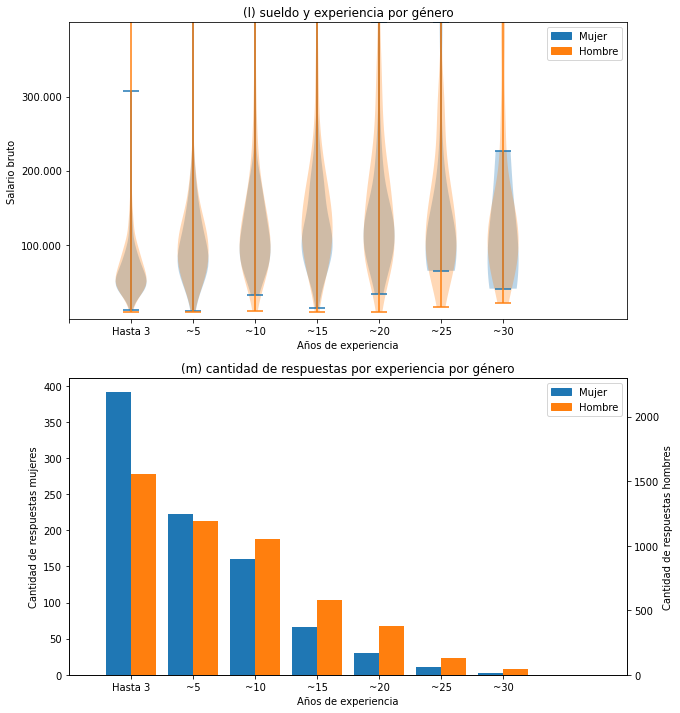

In [85]:
df['exp_round'] = df['Años de experiencia'].apply(lambda x: math.floor(5 * (x // 5)))
totalw = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].shape[0]
totalm = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].shape[0]
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, 9)
ax0.set_xticks(range(8))
ax1.set_xlim(-1, 8)
ax1.set_xticks(range(8))

w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)]
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)]

ax0.legend(['Mujer', 'Hombre', ])
ax0.set_title('(l) sueldo y experiencia por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Años de experiencia')
ax0.set_xticklabels(['', 'Hasta 3', '~5', '~10', '~15', '~20', '~25', '~30'])
ax0.violinplot([
    w[w['Años de experiencia'] <= 3]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(3 < w['Años de experiencia']) & (w['Años de experiencia'] <= 7)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(7 < w['Años de experiencia']) & (w['Años de experiencia'] <= 12)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(12 < w['Años de experiencia']) & (w['Años de experiencia'] <= 17)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(17 < w['Años de experiencia']) & (w['Años de experiencia'] <= 22)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(22 < w['Años de experiencia']) & (w['Años de experiencia'] <= 27)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    w[(27 < w['Años de experiencia']) & (w['Años de experiencia'] <= 32)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
])
ax0.violinplot([
    m[m['Años de experiencia'] <= 3]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(3 < m['Años de experiencia']) & (m['Años de experiencia'] <= 7)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(7 < m['Años de experiencia']) & (m['Años de experiencia'] <= 12)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(12 < m['Años de experiencia']) & (m['Años de experiencia'] <= 17)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(17 < m['Años de experiencia']) & (m['Años de experiencia'] <= 22)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(22 < m['Años de experiencia']) & (m['Años de experiencia'] <= 27)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
    m[(27 < m['Años de experiencia']) & (m['Años de experiencia'] <= 32)]['Salario mensual BRUTO (en tu moneda local)'].to_list(),
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

w = df[(df['Me identifico'] == 'Mujer') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
m = df[(df['Me identifico'] == 'Hombre') & (df['Años de experiencia'] < 33)].groupby('exp_round')['Salario mensual BRUTO (en tu moneda local)']
ax2 = ax1.twinx()
ax1.set_xticks(range(len(w.count().index)))
ax1.set_xticklabels(w.count().index)
ax1.bar([x - 0.2 for x in range(len(w.count().index))], w.count().values, 0.4, color=cm)
ax2.bar([x + 0.2 for x in range(len(m.count().index))], m.count().values, 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])
ax1.set_title('(m) cantidad de respuestas por experiencia por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Años de experiencia')
ax1.set_xticklabels(['Hasta 3', '~5', '~10', '~15', '~20', '~25', '~30'])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

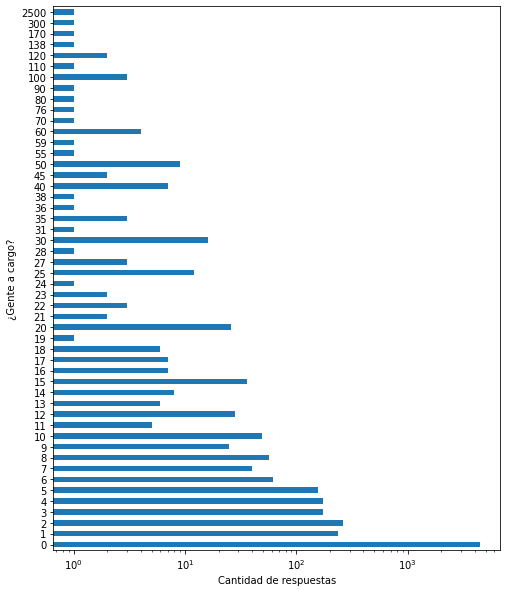

In [86]:
ax = df['¿Gente a cargo?'].fillna(0).astype(int).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('¿Gente a cargo?');
ax.set_xscale('log');

<ipython-input-87-d81633cce171>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([''] + ['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])
<ipython-input-87-d81633cce171>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])


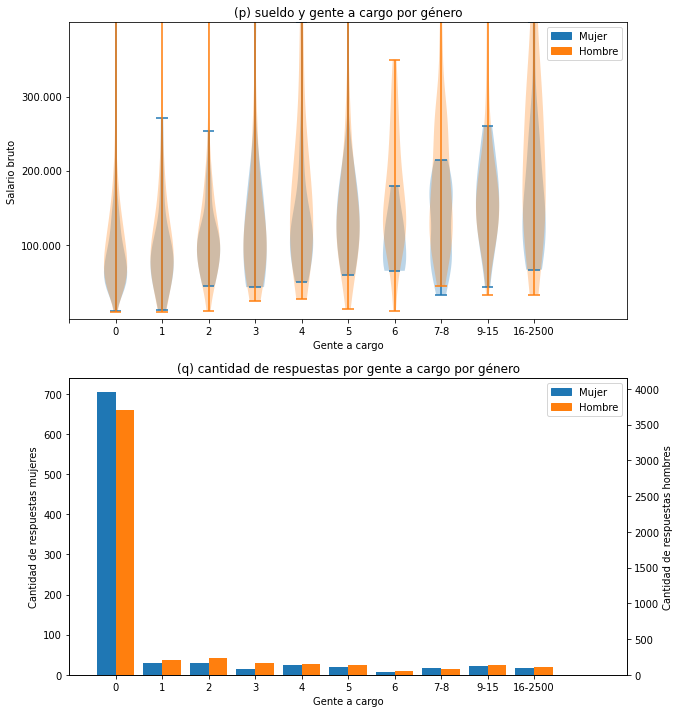

In [87]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
gente_a_cargo_gt_0 = df['¿Gente a cargo?'][df['¿Gente a cargo?'].fillna('0').astype(int) > 0].fillna('0').astype(int)
qs = sorted(set([0]).union(set((int(gente_a_cargo_gt_0.quantile(i / 10)) for i in range(10))))) + [gente_a_cargo_gt_0.max()]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(qs)+2)

ax0.set_title('(p) sueldo y gente a cargo por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Gente a cargo')
ax0.set_xticklabels([''] + ['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])
ax0.set_xticks(range(len(qs)+1))

w = df[df['Me identifico'] == 'Mujer']
wgac = w['¿Gente a cargo?'].astype(int)
ax0.violinplot([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, q in enumerate(qs)
])

m = df[df['Me identifico'] == 'Hombre']
mgac = m['¿Gente a cargo?'].astype(int)
ax0.violinplot([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, q in enumerate(qs)
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


gente_a_cargo_gt_0 = df['¿Gente a cargo?'][df['¿Gente a cargo?'].fillna('0').astype(int) > 0].fillna('0').astype(int)
qs = sorted(set([0]).union(set((int(gente_a_cargo_gt_0.quantile(i / 10)) for i in range(10))))) + [gente_a_cargo_gt_0.max()]
totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(q) cantidad de respuestas por gente a cargo por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Gente a cargo')
ax1.set_xticklabels(['0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)])
ax1.set_xticks(range(len(qs)))
ax1.set_xlim(-1, len(qs)+1)

w = df[df['Me identifico'] == 'Mujer']
wgac = w['¿Gente a cargo?'].astype(int)
ax1.bar([x - 0.2 for x in range(len(qs))], [data for data in [
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))].shape[0] for (i, q) in enumerate(qs)
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
mgac = m['¿Gente a cargo?'].astype(int)
ax2.bar([x + 0.2 for x in range(len(qs))], [data for data in [
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))].shape[0] for (i, q) in enumerate(qs)
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

In [88]:
pd.concat((
pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, q in enumerate(qs)
]).rename('Q1 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, q in enumerate(qs)
]).rename('Q2 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, q in enumerate(qs)
]).rename('Q3 Mujer'), pd.Series([
    w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Mujeres'),
pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, q in enumerate(qs)
]).rename('Q1 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, q in enumerate(qs)
]).rename('Q2 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, q in enumerate(qs)
]).rename('Q3 Hombre'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Hombres'), pd.Series([
    m[mgac == 0 if i == 0 else ((qs[i-1] < mgac) & (mgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] / w[wgac == 0 if i == 0 else ((qs[i-1] < wgac) & (wgac <= q))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, q in enumerate(qs)
]).rename('Hombres por mujer'),
), axis=1).astype(int).T.rename(columns={i: '0' if i == 0 else (str(q) if q == qs[i-1]+1 else f'{qs[i-1]+1}-{q}') for i, q in enumerate(qs)}).T

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres,Hombres por mujer
0,53000,77000,114250,704,62000,94000,140000,3706,5
1,58750,83000,99425,30,65000,90000,135000,205,6
2,70575,99750,122250,30,79250,104000,150000,231,7
3,67750,99000,160000,15,80000,113000,177500,159,10
4,93750,108500,131750,24,94500,149500,232500,148,6
5,98000,131042,176759,19,100750,134500,190750,136,7
6,72500,100000,130939,8,120000,149000,223000,54,6
7-8,80250,135000,173750,18,119500,170000,245500,79,4
9-15,123300,155000,191000,21,123926,160000,210000,136,6
16-2500,100000,145000,215000,16,140767,214500,313328,115,7


<ipython-input-89-2711544cec73>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([f'{d} {s}' for d, s in ds], rotation=45)


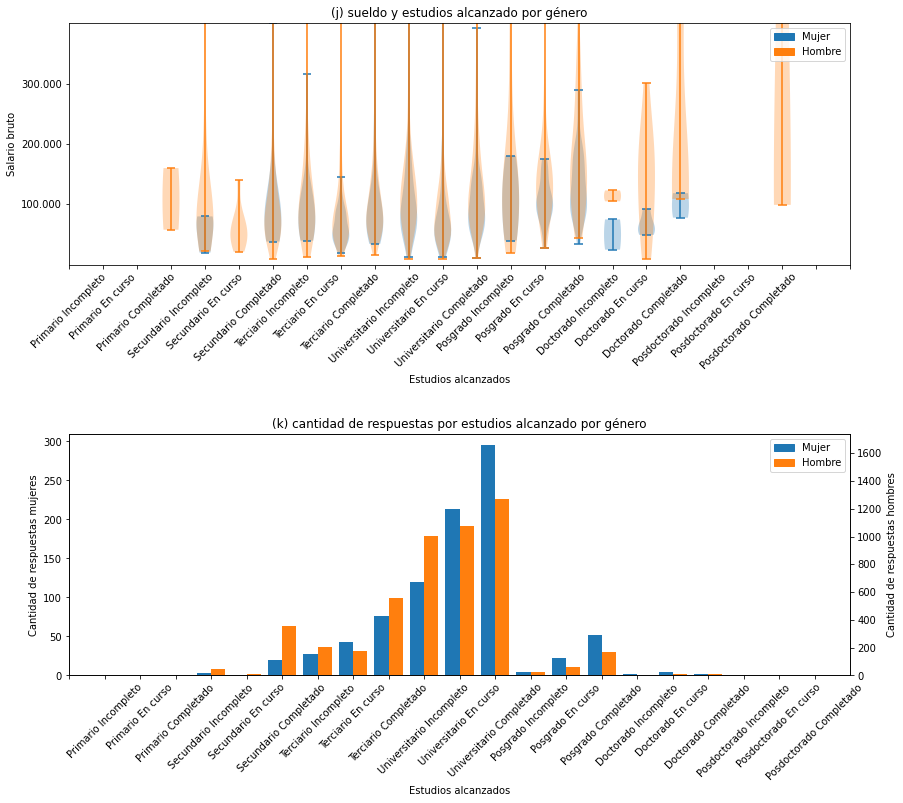

In [89]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(14, 12))
f.subplots_adjust(hspace=0.7)
degrees = 'Primario', 'Secundario', 'Terciario', 'Universitario', 'Posgrado', 'Doctorado', 'Posdoctorado'
degrees_status = 'Incompleto', 'En curso', 'Completado'
ds = [(d, ds) for d in degrees for ds in degrees_status]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(ds)+1)
ax1.set_xticks(range(len(ds)))
ax1.set_xlim(-1, len(ds))

ax0.set_title('(j) sueldo y estudios alcanzado por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Estudios alcanzados')
ax0.set_xticklabels([f'{d} {s}' for d, s in ds], rotation=45)
ax0.set_xticks(range(-1, len(ds)+2))

w = df[df['Me identifico'] == 'Mujer']
wd = w['Nivel de estudios alcanzado']
ws = w['Estado']
ax0.violinplot([data for data in [
    w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
] if len(data) > 1], positions=[i for i, data in enumerate([
    w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
]) if len(data) > 1])

m = df[df['Me identifico'] == 'Hombre']
md = m['Nivel de estudios alcanzado']
ms = m['Estado']
ax0.violinplot([data for data in [
    m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
] if len(data) > 1], positions=[i for i, data in enumerate([
    m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'].to_list() for (d, s) in ds
]) if len(data) > 1])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(k) cantidad de respuestas por estudios alcanzado por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Estudios alcanzados')
ax1.set_xticklabels([f'{d} {s}' for d, s in ds], rotation=45)
ax1.set_xticks(range(-1, len(ds)))

w = df[df['Me identifico'] == 'Mujer']
wd = w['Nivel de estudios alcanzado']
ws = w['Estado']
ax1.bar([x - 0.2 for x in range(len(ds))], [data for data in [
    w[(wd == d) & (ws == s)].shape[0] for (d, s) in ds
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
md = m['Nivel de estudios alcanzado']
ms = m['Estado']
ax2.bar([x + 0.2 for x in range(len(ds))], [data for data in [
    m[(md == d) & (ms == s)].shape[0] for (d, s) in ds
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()
None;

In [90]:
degree_distribution_w = [w[(wd == d) & (ws == s)]['Salario mensual BRUTO (en tu moneda local)'] for (d, s) in ds]
degree_distribution_m = [m[(md == d) & (ms == s)]['Salario mensual BRUTO (en tu moneda local)'] for (d, s) in ds]

pd.concat((
pd.Series([
   degree_distribution_w[i].quantile(0.25) for i, q in enumerate(ds)
]).rename('Q1 Mujer'), pd.Series([
    degree_distribution_w[i].quantile(0.5) for i, q in enumerate(ds)
]).rename('Q2 Mujer'), pd.Series([
    degree_distribution_w[i].quantile(0.75) for i, q in enumerate(ds)
]).rename('Q3 Mujer'), pd.Series([
    degree_distribution_w[i].shape[0] for i, q in enumerate(ds)
]).rename('Mujeres'),
pd.Series([
    degree_distribution_m[i].quantile(0.25) for i, q in enumerate(ds)
]).rename('Q1 Hombre'), pd.Series([
    degree_distribution_m[i].quantile(0.5) for i, q in enumerate(ds)
]).rename('Q2 Hombre'), pd.Series([
    degree_distribution_m[i].quantile(0.75) for i, q in enumerate(ds)
]).rename('Q3 Hombre'), pd.Series([
    degree_distribution_m[i].shape[0] for i, q in enumerate(ds)
]).rename('Hombres'),
), axis=1).fillna(-1).astype(int).T.rename(columns={i: f'{d} {s}' for i, (d, s) in enumerate(ds)}).T

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres
Primario Incompleto,-1,-1,-1,0,-1,-1,-1,0
Primario En curso,-1,-1,-1,0,-1,-1,-1,0
Primario Completado,-1,-1,-1,0,83500,109000,134500,2
Secundario Incompleto,41000,62000,71000,3,56750,85000,130750,44
Secundario En curso,-1,-1,-1,0,40000,51000,70000,9
Secundario Completado,57000,81000,98500,20,53000,80000,121000,353
Terciario Incompleto,55550,80000,110000,27,60500,88000,140000,202
Terciario En curso,43000,57500,83179,43,50000,72220,102000,177
Terciario Completado,54500,78375,120000,76,64000,91760,135000,556
Universitario Incompleto,65697,93000,140250,120,80000,120000,164750,1007


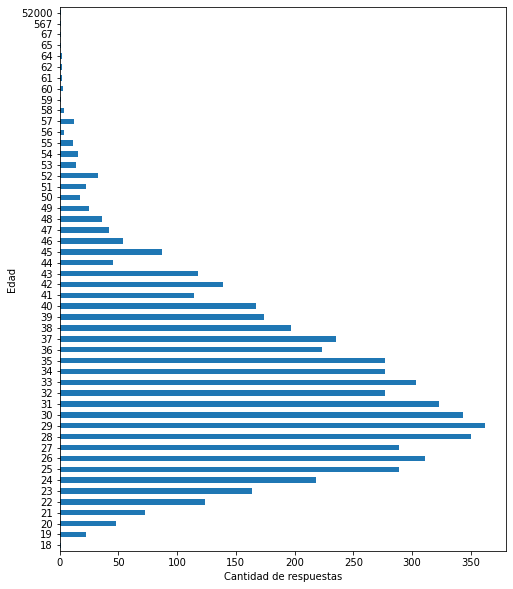

In [91]:
ax = df['Tengo'].apply(math.floor).value_counts().sort_index().plot.barh(figsize=(8, 10));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Edad');

<ipython-input-92-8b17977f8b25>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])
<ipython-input-92-8b17977f8b25>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])


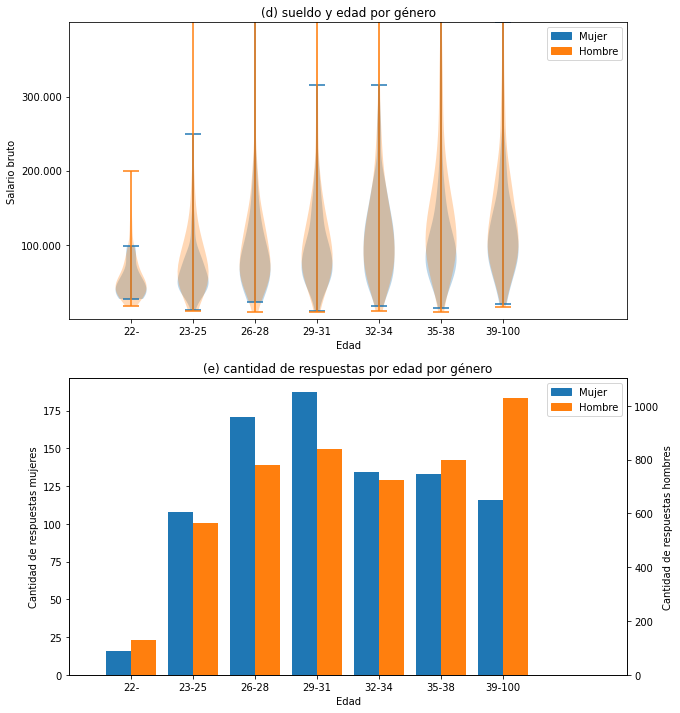

,Q1 Mujer,Q2 Mujer,Q3 Mujer,Mujeres,Q1 Hombre,Q2 Hombre,Q3 Hombre,Hombres
22-,36080,44750,61500,16,35982,50000,70000,128
23-25,42000,56000,78042,108,50000,70000,100000,563
26-28,54000,77000,116500,171,60240,90000,130000,779
29-31,62500,86200,127000,187,67000,96870,140690,841
32-34,67500,104276,144750,134,75000,110000,160000,723
35-38,66500,92000,120000,133,85800,125000,180000,799
39-100,76393,101900,140000,116,90000,125000,180000,1030


In [92]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))
ages = [22, 25, 28, 31, 34, 38, 100]
ax0.set_ylim(0, 400_000)
ax0.set_xlim(0, len(ages)+2)

ax0.set_title('(d) sueldo y edad por género')
ax0.set_yticks([300_000, 200_000, 100_000])
ax0.set_yticklabels(['300.000', '200.000', '100.000'])
ax0.set_ylabel('Salario bruto')
ax0.set_xlabel('Edad')
ax0.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])
ax0.set_xticks(range(1, len(ages)+1))

w = df[df['Me identifico'] == 'Mujer']
wage = w['Tengo'].astype(int)
ax0.violinplot([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, age in enumerate(ages)
])

m = df[df['Me identifico'] == 'Hombre']
mage = m['Tengo'].astype(int)
ax0.violinplot([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].to_list() for i, age in enumerate(ages)
])
ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

ax2 = ax1.twinx()
ax1.set_title('(e) cantidad de respuestas por edad por género')
ax1.set_ylabel('Cantidad de respuestas mujeres')
ax2.set_ylabel('Cantidad de respuestas hombres')
ax1.set_xlabel('Edad')
ax1.set_xticklabels([f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)])
ax1.set_xticks(range(len(ages)))
ax1.set_xlim(-1, len(ages)+1)

w = df[df['Me identifico'] == 'Mujer']
ax1.bar([x - 0.2 for x in range(len(ages))], [data for data in [
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))].shape[0] for (i, age) in enumerate(ages)
]], 0.4, color=cm)

m = df[df['Me identifico'] == 'Hombre']
ax2.bar([x + 0.2 for x in range(len(ages))], [data for data in [
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))].shape[0] for (i, age) in enumerate(ages)
]], 0.4, color=ch)
ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
    ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
else:
    ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

plt.show()

pd.concat((
pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, age in enumerate(ages)
]).rename('Q1 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, age in enumerate(ages)
]).rename('Q2 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, age in enumerate(ages)
]).rename('Q3 Mujer'), pd.Series([
    w[wage < age if i == 0 else ((ages[i-1] < wage) & (wage <= age))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, age in enumerate(ages)
]).rename('Mujeres'),
pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for i, age in enumerate(ages)
]).rename('Q1 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for i, age in enumerate(ages)
]).rename('Q2 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for i, age in enumerate(ages)
]).rename('Q3 Hombre'), pd.Series([
    m[mage < age if i == 0 else ((ages[i-1] < mage) & (mage <= age))]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for i, age in enumerate(ages)
]).rename('Hombres'),
), axis=1).astype(int).T.rename(columns={i: f'{age}-' if i == 0 else f'{ages[i-1]+1}-{age}' for i, age in enumerate(ages)}).T

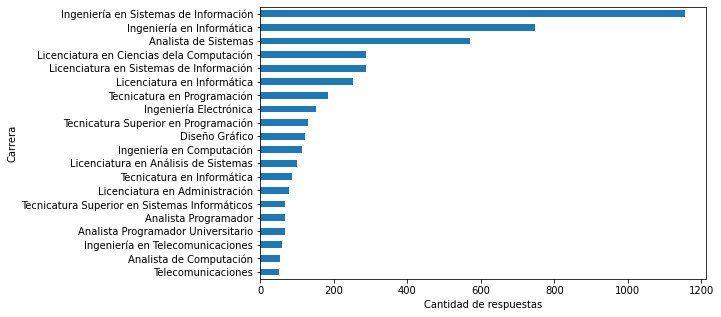

In [93]:
ax = df['Carrera'].value_counts().sort_values().tail(20).plot.barh(figsize=(8, 5));
ax.set_xlabel('Cantidad de respuestas');
ax.set_ylabel('Carrera');

<ipython-input-94-eae273e1303a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
<ipython-input-94-eae273e1303a>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)


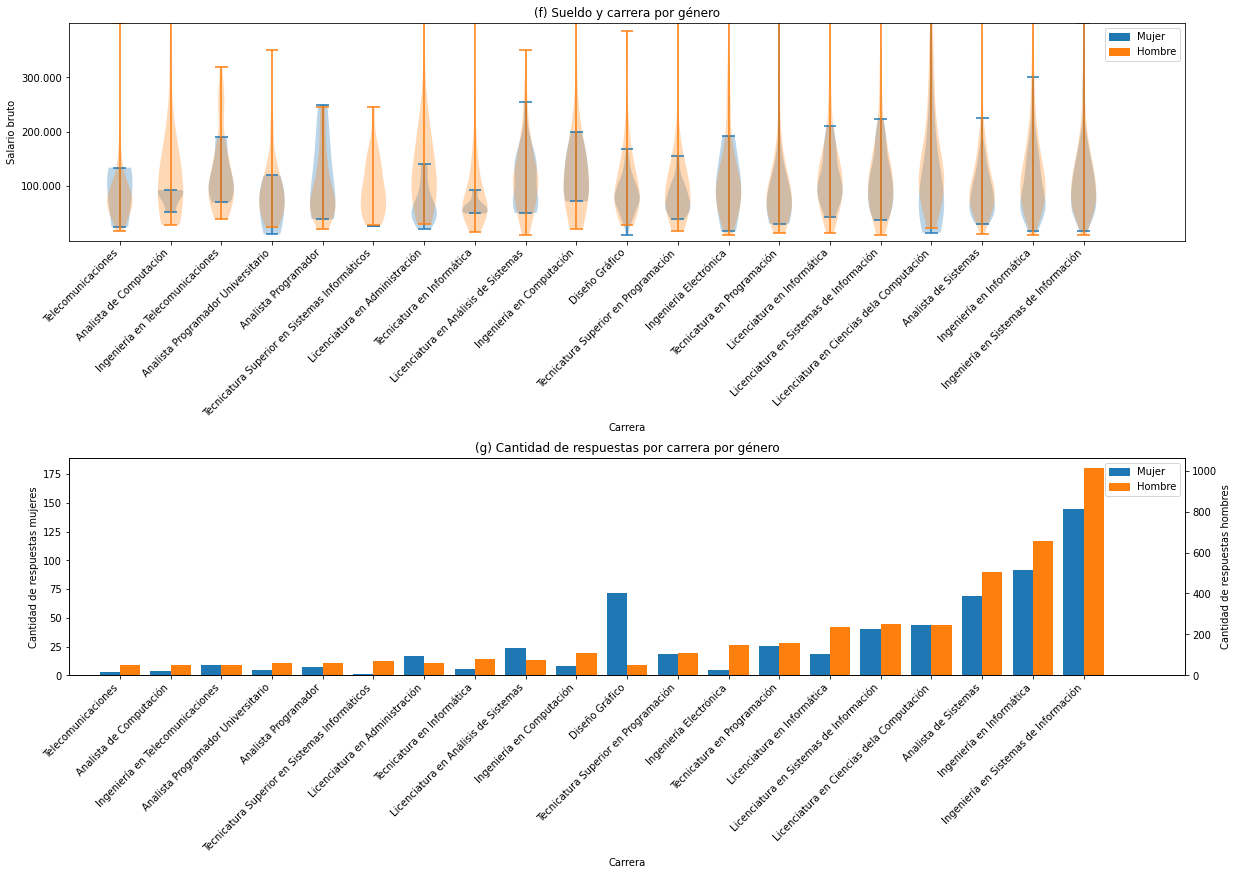

|                                               |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:----------------------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| Telecomunicaciones                            |      62000 |      99000 |     116500 |         3 |       55000 |       75000 |       90000 |        49 |
| Analista de Computación                       |      75250 |      87957 |      92914 |         4 |       58000 |      100000 |      141500 |        49 |
| Ingeniería en Telecomunicaciones              |      90000 |     100000 |     140000 |         9 |       77000 |      104000 |      152500 |        51 |
| Analista Programador Universitario            |      38000 |      73000 |      87000 |         5 |       53500 |       83250 |      111500 |        62 |
| Analista Programador                          |      64500 |      71

In [94]:
def plot_gpg(categories, letter1, title1, label, column, letter2, title2, hspace=None, rotation=None, horizontalalignment=None, figsize=(10, 12)):
    f, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize)
    f.subplots_adjust(hspace=hspace)

    ax0.set_ylim(0, 400_000)
    ax0.set_xlim(0, len(categories)+2)

    ax0.set_title(f'({letter1}) {title1}')
    ax0.set_yticks([300_000, 200_000, 100_000])
    ax0.set_yticklabels(['300.000', '200.000', '100.000'])
    ax0.set_ylabel('Salario bruto')
    ax0.set_xlabel(label)
    ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax0.set_xticks(range(1, 1+len(categories)))

    w = df[df['Me identifico'] == 'Mujer']
    ax0.violinplot([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])

    m = df[df['Me identifico'] == 'Hombre']
    ax0.violinplot([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])
    ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


    totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
    totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

    ax2 = ax1.twinx()
    ax1.set_title(f'({letter2}) {title2}')
    ax1.set_ylabel('Cantidad de respuestas mujeres')
    ax2.set_ylabel('Cantidad de respuestas hombres')
    ax1.set_xlabel(label)
    ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax1.set_xticks(range(0,len(categories)))
    ax1.set_xlim(-1, len(categories)+1)
    ax1.bar([x - 0.2 for x in range(len(categories))], [data for data in [
        w[w[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=cm)
    ax2.bar([x + 0.2 for x in range(len(categories))], [data for data in [
        m[m[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=ch)
    ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

    if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
        ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
    else:
        ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

    plt.show()

    print(
    pd.concat((
    pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for cat in categories
    ]).rename('Q1 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for cat in categories
    ]).rename('Q2 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75)  for cat in categories
    ]).rename('Q3 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Mujeres'),
    pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25)  for cat in categories
    ]).rename('Q1 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5)  for cat in categories
    ]).rename('Q2 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for cat in categories
    ]).rename('Q3 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Hombres'),
    ), axis=1).astype(int).T.rename(columns={i: cat for i, cat in enumerate(categories)}).T
    .to_markdown())

plot_gpg(
    categories=df['Carrera'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='f',
    title1='Sueldo y carrera por género',
    label='Carrera',
    column='Carrera',
    letter2='g',
    title2='Cantidad de respuestas por carrera por género',
    hspace=1,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

<ipython-input-94-eae273e1303a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
<ipython-input-94-eae273e1303a>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)


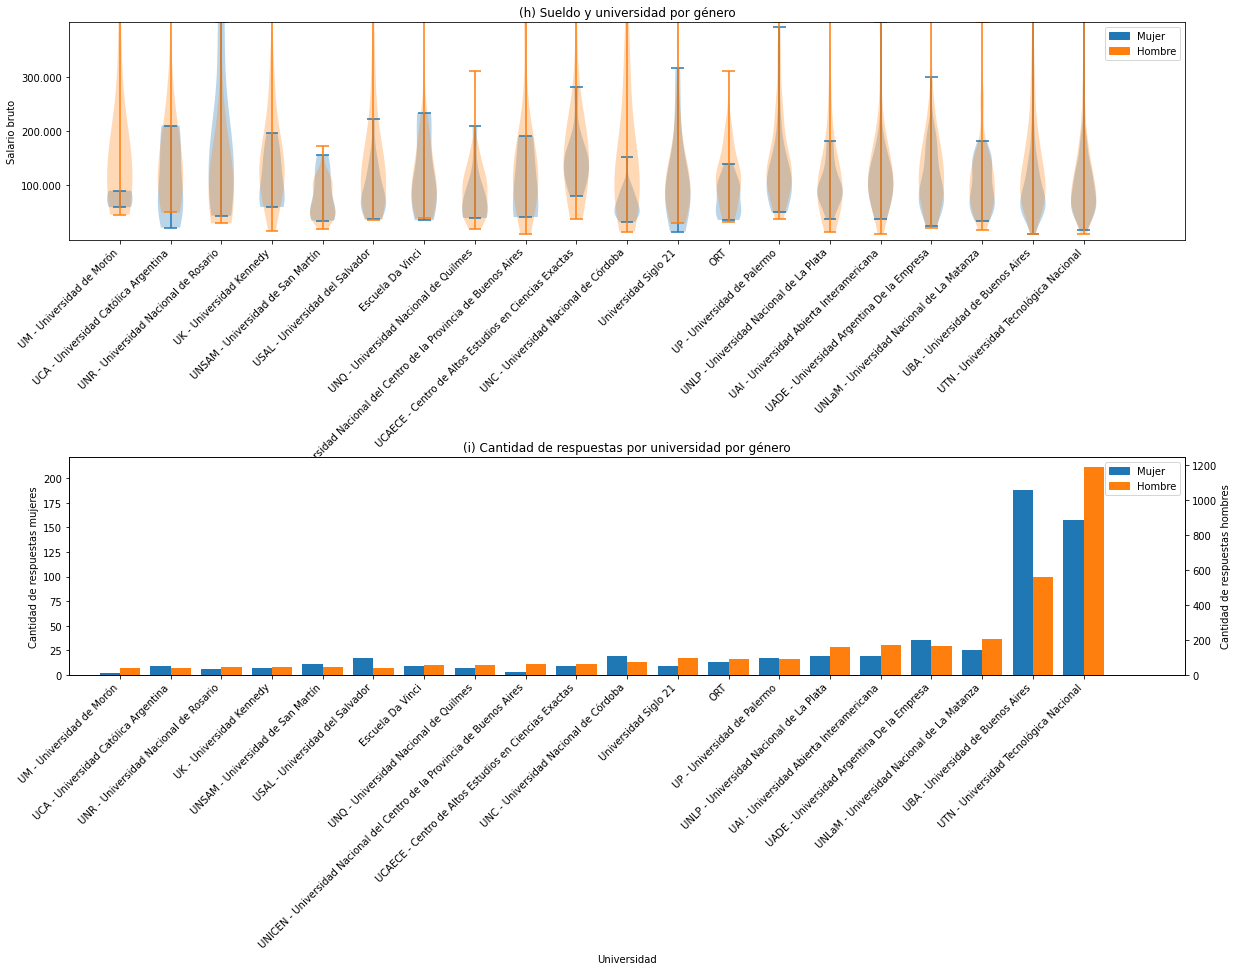

|                                                                          |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-------------------------------------------------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| UM - Universidad de Morón                                                |      67500 |      75000 |      82500 |         2 |       80000 |      116000 |      189000 |        37 |
| UCA - Universidad Católica Argentina                                     |      63500 |     100000 |     180000 |         9 |       85000 |      130000 |      180000 |        37 |
| UNR - Universidad Nacional de Rosario                                    |      88750 |     140812 |     187906 |         6 |       65662 |       91500 |      128867 |        44 |
| UK - Universidad Kennedy                                                 |      69000 | 

In [95]:
plot_gpg(
    categories=df['Universidad'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='h',
    title1='Sueldo y universidad por género',
    label='Universidad',
    column='Universidad',
    letter2='i',
    title2='Cantidad de respuestas por universidad por género',
    hspace=1,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

<ipython-input-96-7917b9da8d1d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
<ipython-input-96-7917b9da8d1d>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)


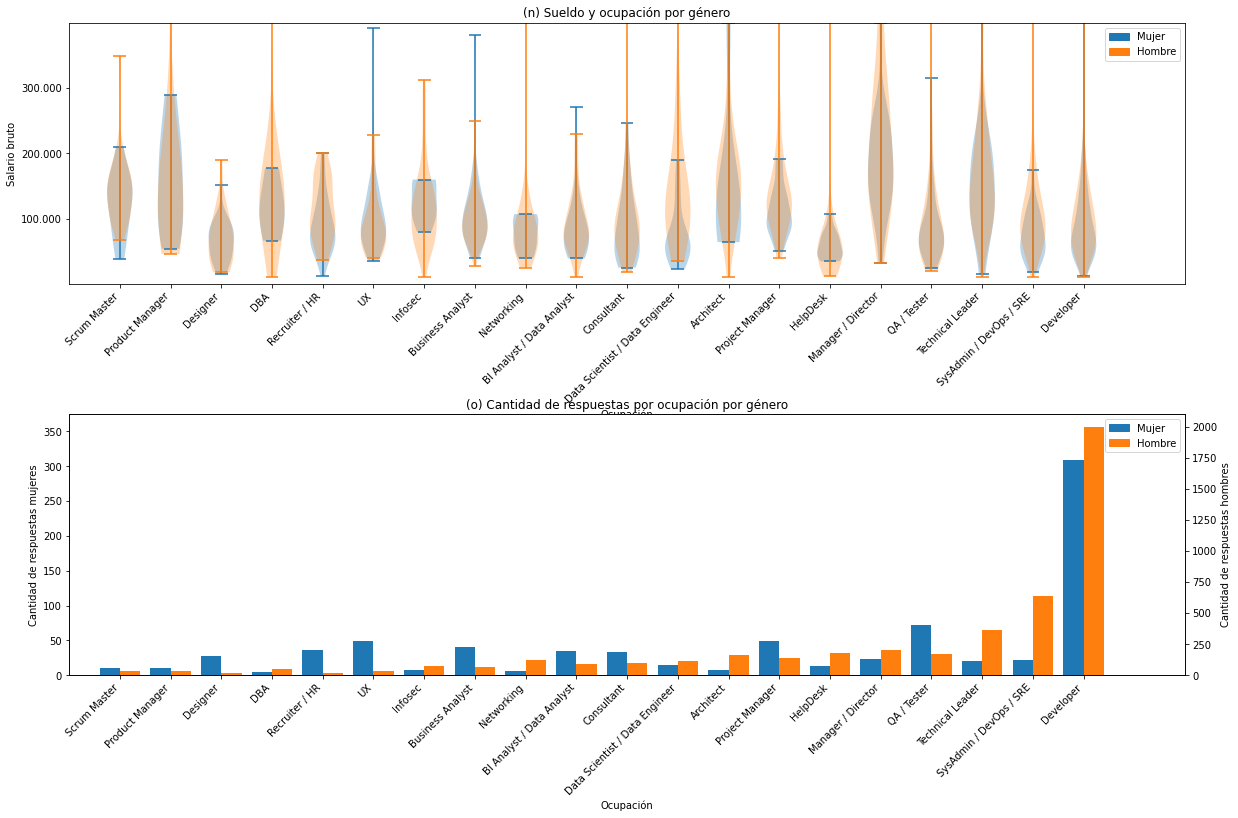

|                                |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-------------------------------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| Scrum Master                   |      88325 |     138500 |     153722 |        10 |      103500 |      140000 |      162524 |        36 |
| Product Manager                |      96004 |     173518 |     205000 |        11 |      100000 |      132500 |      175250 |        38 |
| Designer                       |      42250 |      66427 |      83500 |        28 |       38000 |       70000 |       85000 |        21 |
| DBA                            |      97500 |     114000 |     134250 |         4 |       97172 |      120000 |      161000 |        48 |
| Recruiter / HR                 |      65000 |      80000 |     110000 |        37 |       80500 |      103000 |      163000 |        15 |
| UX                

In [96]:
def plot_gpg(categories, letter1, title1, label, column, letter2, title2, hspace=None, rotation=None, horizontalalignment=None, figsize=(10, 12)):
    f, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize)
    f.subplots_adjust(hspace=hspace)

    ax0.set_ylim(0, 400_000)
    ax0.set_xlim(0, len(categories)+2)

    ax0.set_title(f'({letter1}) {title1}')
    ax0.set_yticks([300_000, 200_000, 100_000])
    ax0.set_yticklabels(['300.000', '200.000', '100.000'])
    ax0.set_ylabel('Salario bruto')
    ax0.set_xlabel(label)
    ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax0.set_xticks(range(1, 1+len(categories)))


    w = df[df['Me identifico'] == 'Mujer']

    ax0.violinplot([data for data in [
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ] if len(data) > 1], positions=[1+i for i, data in enumerate([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ]) if len(data) > 1])


    m = df[df['Me identifico'] == 'Hombre']
    ax0.violinplot([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].to_list() for cat in categories
    ])
    ax0.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])


    totalw = df[df['Me identifico'] == 'Mujer'].shape[0]
    totalm = df[df['Me identifico'] == 'Hombre'].shape[0]

    ax2 = ax1.twinx()
    ax1.set_title(f'({letter2}) {title2}')
    ax1.set_ylabel('Cantidad de respuestas mujeres')
    ax2.set_ylabel('Cantidad de respuestas hombres')
    ax1.set_xlabel(label)
    ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
    ax1.set_xticks(range(0,len(categories)))
    ax1.set_xlim(-1, len(categories)+1)
    ax1.bar([x - 0.2 for x in range(len(categories))], [data for data in [
        w[w[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=cm)
    ax2.bar([x + 0.2 for x in range(len(categories))], [data for data in [
        m[m[column] == cat].shape[0] for cat in categories
    ]], 0.4, color=ch)
    ax1.legend([mpatches.Patch(color=cm), mpatches.Patch(color=ch)], ['Mujer', 'Hombre', ])

    if ax1.set_ylim()[1] / totalw > ax2.set_ylim()[1] / totalm:
        ax2.set_ylim(0, totalm * ax1.set_ylim()[1] / totalw)
    else:
        ax1.set_ylim(0, totalw * ax2.set_ylim()[1] / totalm)

    plt.show()

    print(
    pd.concat((
    pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25) for cat in categories
    ]).rename('Q1 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5) for cat in categories
    ]).rename('Q2 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75)  for cat in categories
    ]).rename('Q3 Mujer'), pd.Series([
        w[w[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Mujeres'),
    pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.25)  for cat in categories
    ]).rename('Q1 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.5)  for cat in categories
    ]).rename('Q2 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].quantile(0.75) for cat in categories
    ]).rename('Q3 Hombre'), pd.Series([
        m[m[column] == cat]['Salario mensual BRUTO (en tu moneda local)'].shape[0] for cat in categories
    ]).rename('Hombres'),
    ), axis=1).fillna(-1).astype(int).T.rename(columns={i: cat for i, cat in enumerate(categories)}).T
    .to_markdown())

plot_gpg(
    categories=df['Trabajo de'].value_counts().sort_values().tail(20).index.tolist(),
    letter1='n',
    title1='Sueldo y ocupación por género',
    label='Ocupación',
    column='Trabajo de',
    letter2='o',
    title2='Cantidad de respuestas por ocupación por género',
    hspace=0.5,
    rotation=45,
    horizontalalignment='right',
    figsize=(20, 12)
)

<ipython-input-96-7917b9da8d1d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)
<ipython-input-96-7917b9da8d1d>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotation, horizontalalignment=horizontalalignment)


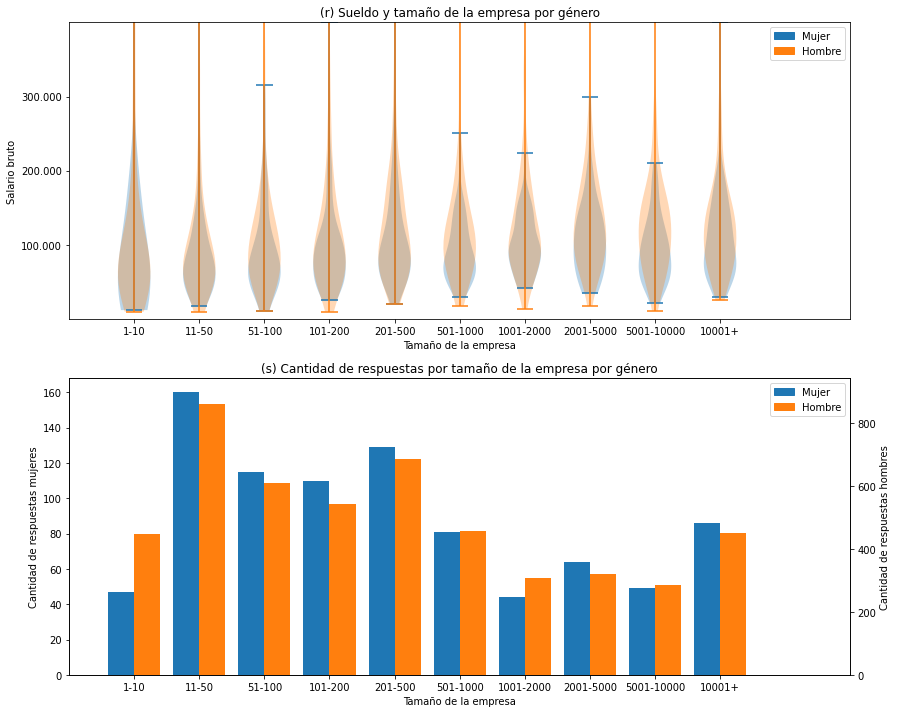

|            |   Q1 Mujer |   Q2 Mujer |   Q3 Mujer |   Mujeres |   Q1 Hombre |   Q2 Hombre |   Q3 Hombre |   Hombres |
|:-----------|-----------:|-----------:|-----------:|----------:|------------:|------------:|------------:|----------:|
| 1-10       |      37500 |      60000 |     127750 |        47 |       48737 |       78000 |      140200 |       447 |
| 11-50      |      49878 |      71500 |     101750 |       160 |       55000 |       82000 |      130000 |       860 |
| 51-100     |      53500 |      75000 |     115167 |       115 |       63500 |       96000 |      140000 |       609 |
| 101-200    |      52700 |      83550 |     110000 |       110 |       65000 |       96600 |      149200 |       544 |
| 201-500    |      65000 |      90000 |     136000 |       129 |       73000 |      110000 |      170000 |       685 |
| 501-1000   |      64000 |      81000 |     117000 |        81 |       77000 |      106478 |      150000 |       457 |
| 1001-2000  |      73750 |      93457 |

In [97]:
plot_gpg(
    categories=sorted(df['Cantidad de empleados'].unique().tolist(), key=lambda v: int(v.strip('+').split('-')[0])),
    letter1='r',
    title1='Sueldo y tamaño de la empresa por género',
    label='Tamaño de la empresa',
    column='Cantidad de empleados',
    letter2='s',
    title2='Cantidad de respuestas por tamaño de la empresa por género',
    horizontalalignment='center',
    figsize=(14, 12)
)